# Collaborative Filtering with Surprise

This notebooks uses the high level Surprise library for user-user and item-item  collaborative filtering.

In [1]:
# Import standard libraries
import numpy as np
import math
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from collections import Counter
from time import sleep
from collections import defaultdict

# Import packages from Surprise
from surprise import KNNBasic, KNNWithMeans, KNNBaseline, KNNWithZScore
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

# Import sklearn packages
from sklearn.metrics import confusion_matrix, pairwise_distances, mean_squared_error
from sklearn import metrics

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


### Functions

In [2]:
def train_test_convert(train_df, test_df):
    '''
    Function that converts train and test dataframes into
    train and test objects that Surpise can read.
    
    Arguments:
    - train_df  :  train dataframe ("customer_id", "product_title", "star_rating") 
    - test_df   :  test dataframe ("customer_id", "product_title", "star_rating")
    
    Returns:
    - trainset  :  train_df as trainset object
    - testset   :  test_df as list of tuples
    '''
    # Convert train
    # A reader is still needed but only the rating_scale param is requiered.
    reader = Reader(rating_scale=(1, 5))
    # The columns must correspond to user id, item id and ratings (in that order).
    data = Dataset.load_from_df(train_df[['customer_id', 'product_title', 'star_rating']], reader)
    trainset = data.build_full_trainset()
    
    # Convert test
    test_df['star_rating'] = test_df['star_rating'].astype('float64')
    testset = [tuple(x) for x in test_df.values]
    
    return trainset, testset
    

In [3]:
def plot_rmse(k_range, trainset, testset, algorithm='KNNWithMeans', sim_options={}):
    '''
    Function which takes in a range of K nearest neighbors values.
    Calculates the RMSE on train and test for each K and plots this.
    
    Arguments:
    - k_range    :  range of k-nearest-neighbors to try
    - trainset   :  trainset as trainset object
    - testset    :  testset as list of tuples
    - algorithm  :  type of algorithm
    
    Returns:
    - scores_df  :  dataframe of rmse at each k
    '''
    
    scores_dict = {'k': [], 'test_rmse': []}
    
    for k in k_range:
        if algorithm == 'KNNBasic':
            algo = KNNBasic(k=k, sim_options=sim_options, verbose=False)
        elif algorithm == 'KNNWithMeans':
            algo = KNNWithMeans(k=k, sim_options=sim_options, verbose=False)
        elif algorithm == 'KNNBaseline':
            algo = KNNBaseline(k=k, sim_options=sim_options, verbose=False)
        elif algorithm == 'KNNWithZScore':
            algo = KNNWithZScore(k=k, sim_options=sim_options, verbose=False)
            
        algo.fit(trainset)

        test_pred = algo.test(testset)
        test_rmse = accuracy.rmse(test_pred, verbose=False)
        
        scores_dict['k'].append(k)
        scores_dict['test_rmse'].append(test_rmse)
    
    scores_df = pd.DataFrame(scores_dict)
    
    plt.figure(figsize=(10,7));
    plt.plot(scores_df['k'], scores_df['test_rmse']);
    plt.title('RMSE for Different Values of K', fontsize=15);
    plt.xlabel('K');
    plt.ylabel('RMSE');
    
    return scores_df
        

In [4]:
def get_n_recommendations(predictions, n=15):
    '''
    Return the top-n recommendations for each user from a set of predictions.

    Arguments:
    - predictions  :  list of prediction objects, returned by the algorithm (algo).
    - n            :  Number of recommendations to output for each user.

    Returns:
    - top_n        :  A dictionary where keys are user ids and values are lists of tuples of size n.
    '''
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [5]:
def print_customer_prof(train_df, test_df, top_n, customer=10345078):
    '''
    Function which looks at an example of a user's ratings and recommendations made
    
    Arguments:
    - customer  :  customer id
    - train_df  :  train dataframe
    - test_df   :  test dataframe
    - top_n     :  dictionary of predictions 
    
    Prints:
    - customer's pre-2014 ratings
    - customer's post-2014 ratings
    - recommendations
    '''

    print('Pre-2014 selections (customer id - {}):'.format(customer))
    print(train_df[train_df['customer_id']==customer][['product_title','star_rating']])
    
    print('\nPost-2014 selections (customer id - {}):'.format(customer))
    print(test_df[test_df['customer_id']==customer][['product_title','star_rating']])
    
    print('\nRecommendations:')
    for i in top_n[customer]:
        print(i[0])

In [6]:
def evaluate_precision(top_n_recs, testset, threshold=4.0):
    '''
    Function which calculates the average recall score of the test set.
    Recall here is defined as the number of recommendations the user actually liked in the test set.
    
    Arguments:
    - top_n_recs  :  dictionary of top N predictions for all users
    - testset     :  test_df as list of tuples 
    - threshold   :  what is considered a like by a customer
    
    Returns:
    - ave_recall  :  average recall score across all test users
    '''
    
    # Convert testset into dictionary with user as key and items they rated as values
    test_dict = defaultdict(list)
    for uid, iid, r in testset:
        test_dict[uid].append((iid, r))
    
    hit_list = []
    for user, ratings in test_dict.items():

        actual_liked = [i for i, r in ratings if r >= threshold]
        preds = [i[0] for i in top_n_recs[user]]

        hits = (set(actual_liked) & set(preds))

        hit_rate = len(hits)/len(preds)
        hit_list.append(hit_rate)
    
    ave_recall = np.mean(hit_list)
    
    return ave_recall

In [7]:
def evaluate_map(top_n_recs, testset, threshold=4.0):
    '''
    Function which calculates the mean average precision (MAP) for each user and returns the mean of these values
    
    Arguments:
    - top_n_recs  :  dictionary of top N predictions for all users
    - testset     :  test_df as list of tuples 
    - threshold   :  what is considered a like by a customer
    
    Returns:
    - mean_map  :  mean MAP across all users
    '''
    
    # Convert testset into dictionary with user as key and items they rated as values
    test_dict = defaultdict(list)
    for uid, iid, r in testset:
        test_dict[uid].append((iid, r))
    
    aps = []
    for user, ratings in test_dict.items():

        actual_liked = [i for i, r in ratings if r >= threshold]
        recommendations = [i[0] for i in top_n_recs[user]]
        
        precisions = []
        recalls = []
        for i, rec in enumerate(recommendations):
            
            hits = (set(actual_liked) & set(recommendations[:i+1]))
            prec = len(hits)/(i+1)
            
            if len(hits) >= 1:
                change_recall = 1/len(actual_liked)
            else:
                change_recall = 0
            
            precisions.append(prec)
            recalls.append(change_recall)

        ap = np.sum([prec * chg_rec for prec, chg_rec in zip(precisions, recalls)])
        aps.append(ap)
    
    mean_map = np.mean(aps)
    
    return mean_map

In [8]:
def new_recommendations(new_products, orig_data, algo):
    '''
    Function that takes in a list of new products and returns recommendations.
    
    Arguments:
    - new_products   :  list of products chosen by new user
    - orig_data      :  original dataframe of users, items and ratings
    
    Returns:
    - recs_df        :  dataframe of recommendations
    '''
    # Append new customer to data
    new_data = pd.DataFrame({'customer_id':[1]*len(new_products), 
                             'product_title':new_products, 
                             'star_rating':[5]*len(new_products)})
    full_data = pd.concat([new_data, orig_data]).reset_index(drop=True)
    
    # A reader is still needed but only the rating_scale param is requiered.
    reader = Reader(rating_scale=(1, 5))

    # The columns must correspond to user id, item id and ratings (in that order)
    data = Dataset.load_from_df(full_data[['customer_id', 'product_title', 'star_rating']], reader)
    
    # Convert to surprise.trainset.Trainset object
    trainset = data.build_full_trainset()
    
    # Train model
    algo.fit(trainset)
    
    # Recommendations dictionary to convert into datframe
    recommendations = {'items': [], 'rating': []}
    
    for item in orig_data['product_title'].unique():
        rating = algo.predict(1, item, verbose=False)[3]
        recommendations['items'].append(item)
        recommendations['rating'].append(rating)
    
    recs_df = pd.DataFrame(recommendations).sort_values(by='rating', ascending=False)
    
    return recs_df

In [9]:
def scores_df(scores):
    '''
    Function which takes in a list of models and returns a dataframe of the models and their scores.
    
    Arguments:
    - scores   :  list of models and their scores
    
    Returns:
    - df       :  dataframe of models and their scores
    '''
    scores_dict = {'Model': [],
                  'RMSE': [],
                  'Unranked Precision': [],
                  'MAP': []}
    
    for score in scores:
        # Update dictionary with model and results
        scores_dict['Model'].append(score['Model'])
        scores_dict['RMSE'].append(score['RMSE'])
        scores_dict['Unranked Precision'].append(score['Unranked Precision'])
        scores_dict['MAP'].append(score['MAP'])
    
    df = pd.DataFrame(scores_dict)
            
    return df

### Load in Data

In [10]:
# Read in Data
sqlite_db = 'datasets/amzn_vg_clean.db'
conn = sqlite3.connect(sqlite_db) 

query = '''
SELECT "customer_id", "product_title", "star_rating"
FROM full_dataset
'''

whole = pd.read_sql(query, con=conn)
print(whole.shape)
whole.head()

(33514, 3)


,customer_id,product_title,star_rating
0,52125818,Battlefield 4,2
1,11725302,Battlefield 4,4
2,17479613,Battlefield 4,4
3,14460182,Battlefield 4,4
4,38739728,Battlefield 4,3


In [11]:
# See number of unique users and products
print(len(whole['customer_id'].unique()))
print(len(whole['product_title'].unique()))

13289
224


In [12]:
# Read in train and test sets
sqlite_db = 'datasets/amzn_vg_clean.db'
conn = sqlite3.connect(sqlite_db) 

train_query = '''
SELECT "customer_id", "product_title", "star_rating"
FROM trainset
'''
test_query = '''
SELECT "customer_id", "product_title", "star_rating"
FROM testset
'''

train_df = pd.read_sql(train_query, con=conn)
test_df = pd.read_sql(test_query, con=conn)
print(train_df.shape)
print(test_df.shape)


(28830, 3)
(4684, 3)


In [13]:
# Split train and test
trainset, testset = train_test_convert(train_df, test_df)

<br>
## 1.A. User-User Collaborative Filtering (KNNBasic - MSD)

A basic collaborative filtering algorithm.

$${\normalsize \hat{r}_{ui} = \frac{\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v) \cdot r_{vi}}{\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
${v \in N^k_i(u)}$ - $v$ users in $k$ neighborhood most similar to user $u$ for item $i$.<br>
$\text{sim}(u, v)$ - **MSD** similarity between user $u$ and $v$.<br>
$r_{vi}$ - Rating for user $v$ and item $i$.<br>

### 1.A.1. Train Model

In [14]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNBasic(k=50, sim_options={'name': 'msd', 'user_based': True})
algo.fit(trainset)


Computing the msd similarity matrix...
Done computing similarity matrix.


### 1.A.2. Evaluate Model (RMSE)

In [15]:
# Evaluate test set
print("User-based (KNNBasic - MSD) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

User-based (KNNBasic - MSD) Model : Test Set
RMSE: 1.2800


**Search Best K based on RMSE**

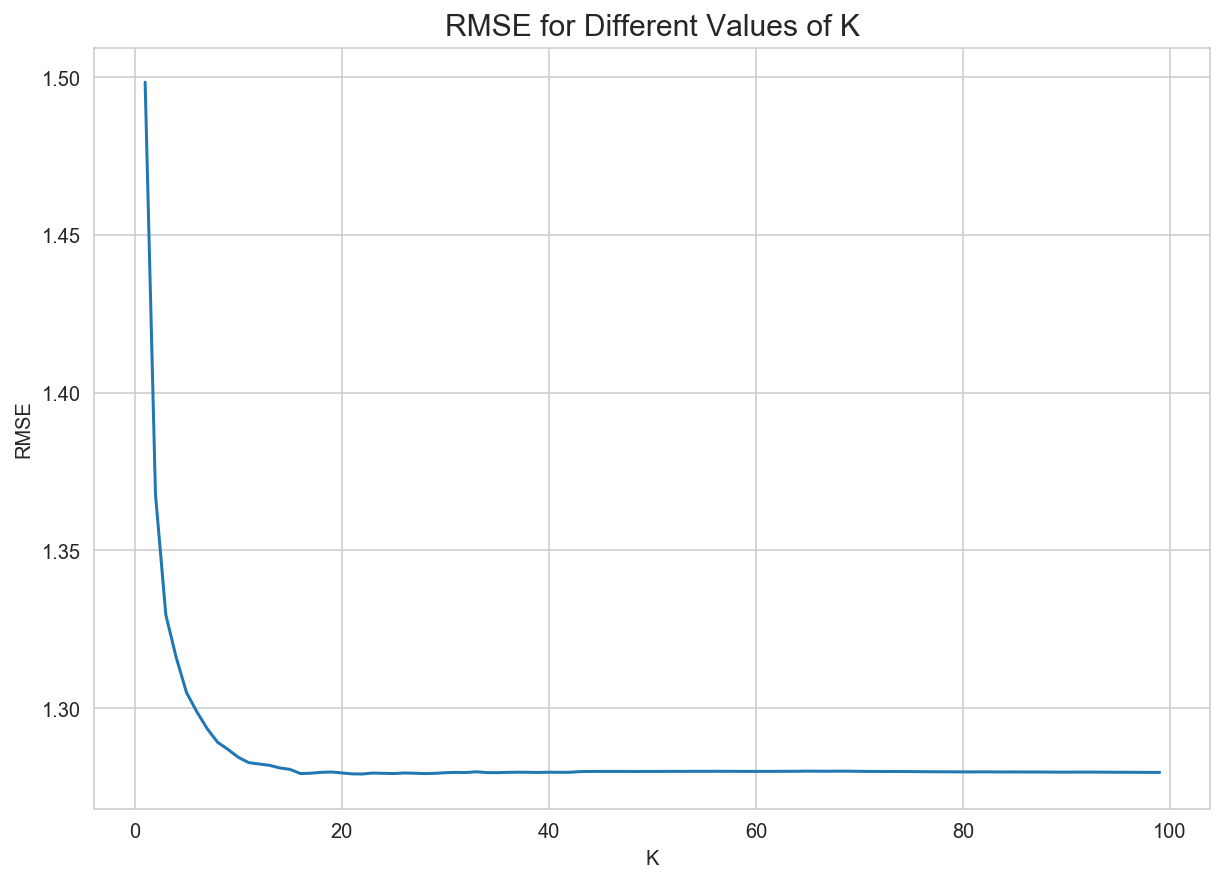

In [16]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNBasic', 
                   sim_options={'name': 'msd', 'user_based': True})

In [17]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
21,22,1.279143
20,21,1.279182
27,28,1.279275
24,25,1.279286
15,16,1.279291


In [18]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNBasic(k=best_k, sim_options={'name': 'msd', 'user_based': True})
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


### 1.A.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [19]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [20]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 10345078):
                                        product_title  star_rating
1621                            God of War: Ascension            5
4031                   Mortal Kombat Komplete Edition            5
5094                   Uncharted 3: Drake's Deception            5
5568     Batman: Arkham City Game of the Year Edition            5
7888                                  Resident Evil 6            5
14548      Call of Duty: Black Ops II - PlayStation 3            5
16008                      Need for Speed Most Wanted            5
17495                                    Dead Space 3            5
17997                                   Battlefield 3            5
18677                                     Max Payne 3            5
19033                   Assassin's Creed: Brotherhood            5
19200                            Assassin's Creed III            5
22727                                        LA Noire            5
23741           

In [21]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (UU - KNNBasic - MSD):', prec)


Precision (UU - KNNBasic - MSD): 0.005952841128720527


In [22]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (UU - KNNBasic - MSD):', mean_ap)


MAP (UU - KNNBasic - MSD): 0.05682269324414458


In [23]:
algo_1A = {'Model': 'UU - KNNBasic - MSD',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [24]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNBasic',
#             sim_options={'name': 'cosine', 'user_based': True})

### 1.A.4. Make Recommendations for New Customer

In [25]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Computing the msd similarity matrix...
Done computing similarity matrix.


,items,rating
216,Civilization 3,5.0
128,Lego Star Wars: The Complete Saga,5.0
219,Roller Coaster Tycoon,5.0
146,Super Mario 64,5.0
27,Call of Duty: Ghosts,5.0
143,Mario Kart: Double Dash,5.0
218,Animal Crossing: Wild World,5.0
140,Super Smash Bros Melee,5.0
38,Kingdom Hearts 3D Dream Drop Distance,5.0
160,The Elder Scrolls Anthology,5.0


<br>

## 1.B. User-User Collaborative Filtering (KNNBasic - Pearson-baseline)

A basic collaborative filtering algorithm.

$${\normalsize \hat{r}_{ui} = \frac{\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v) \cdot r_{vi}}{\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
${v \in N^k_i(u)}$ - $v$ users in $k$ neighborhood most similar to user $u$ for item $i$.<br>
$\text{sim}(u, v)$ - **Pearson-baseline** similarity between user $u$ and $v$.<br>
$r_{vi}$ - Rating for user $v$ and item $i$.<br>

### 1.B.1. Train Model

In [26]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNBasic(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### 1.B.2. Evaluate Model (RMSE)

In [27]:
# Evaluate test set
print("User-based (II - KNNBasic - Pearson-baseline) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

User-based (II - KNNBasic - Pearson-baseline) Model : Test Set
RMSE: 1.3093


**Search Best K based on RMSE**

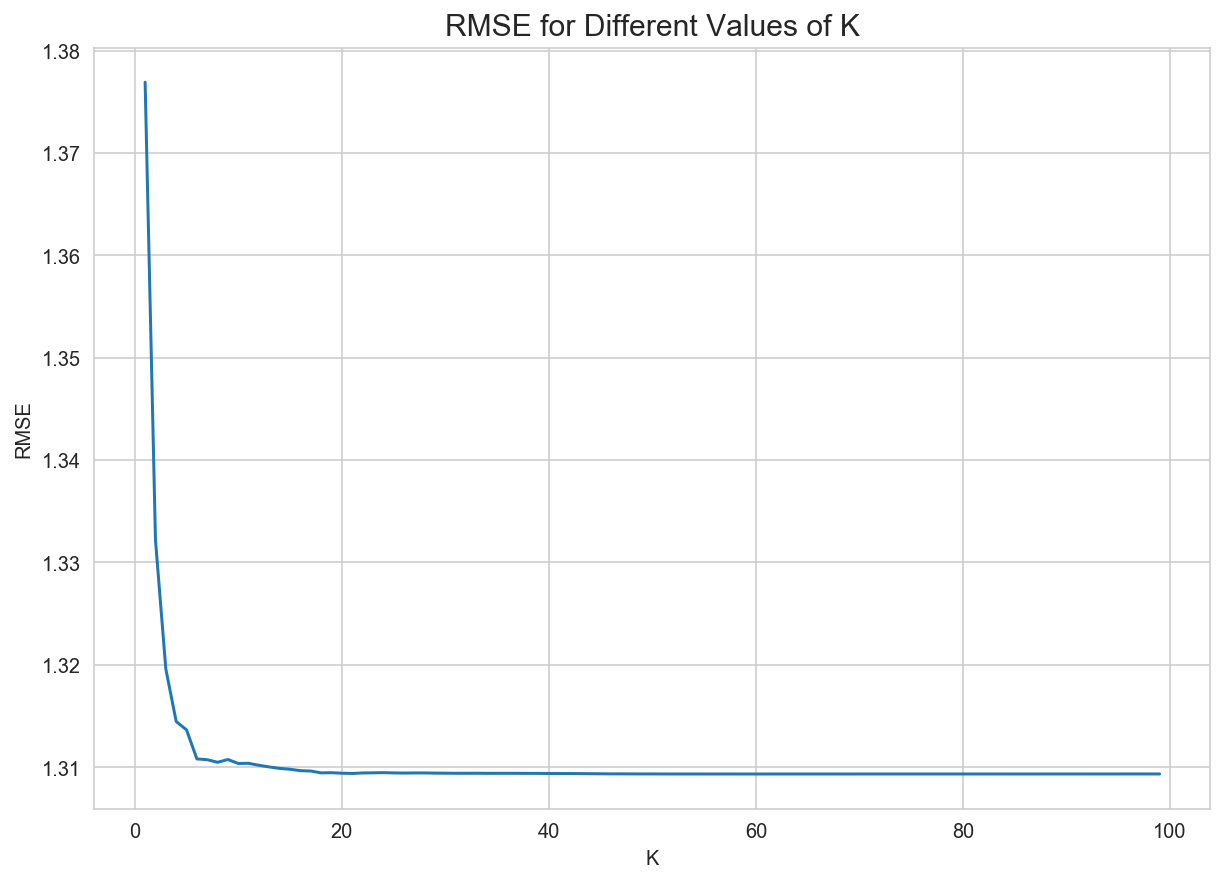

In [28]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNBasic', 
                   sim_options={'name': 'pearson_baseline', 'user_based': True})

In [29]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
57,58,1.309336
59,60,1.309336
54,55,1.309336
55,56,1.309336
58,59,1.309336


In [30]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNBasic(k=best_k, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### 1.B.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [31]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [32]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 10345078):
                                        product_title  star_rating
1621                            God of War: Ascension            5
4031                   Mortal Kombat Komplete Edition            5
5094                   Uncharted 3: Drake's Deception            5
5568     Batman: Arkham City Game of the Year Edition            5
7888                                  Resident Evil 6            5
14548      Call of Duty: Black Ops II - PlayStation 3            5
16008                      Need for Speed Most Wanted            5
17495                                    Dead Space 3            5
17997                                   Battlefield 3            5
18677                                     Max Payne 3            5
19033                   Assassin's Creed: Brotherhood            5
19200                            Assassin's Creed III            5
22727                                        LA Noire            5
23741           

In [33]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (II - KNNBasic - Pearson-baseline):', prec)


Precision (II - KNNBasic - Pearson-baseline): 0.013039556758149723


In [34]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (II - KNNBasic - Pearson-baseline):', mean_ap)


MAP (II - KNNBasic - Pearson-baseline): 0.14959922794818284


In [35]:
algo_1B = {'Model': 'UU - KNNBasic - Pearson-baseline',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [36]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNBasic',
#             sim_options={'name': 'pearson', 'user_based': True})

### 1.B.4. Make Recommendations for New Customer

In [37]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


,items,rating
211,Grand Theft Auto III - PS2,5.0
39,Kingdom Hearts HD 1.5 Remix,5.0
26,Mortal Kombat Komplete Edition,5.0
149,Gran Turismo 6,5.0
64,Assassins Creed II,5.0
110,Assassin's Creed Ezio Trilogy Edition,5.0
33,Metal Gear Solid 4: Guns of the Patriots,5.0
150,Metal Gear Solid: The Legacy Collection,5.0
35,LittleBigPlanet,5.0
156,Need for Speed: Hot Pursuit,5.0


<br>
## 2.A. Item-Item Collaborative Filtering (KNNBasic - MSD)

A basic collaborative filtering algorithm.

$${\normalsize \hat{r}_{ui} = \frac{\sum\limits_{j \in N^k_u(i)} \text{sim}(i, j) \cdot r_{uj}}{\sum\limits_{j \in N^k_u(i)} \text{sim}(i, j)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
${j \in N^k_u(i)}$ - $j$ items in $k$ neighborhood most similar to item $i$ for user $u$.<br>
$\text{sim}(i, j)$ - **MSD** similarity between item $i$ and $j$.<br>
$r_{uj}$ - Rating for item $j$ and user $u$.<br>

### 2.A.1. Train Model

In [38]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNBasic(k=50, sim_options={'name': 'msd', 'user_based': False})
algo.fit(trainset)


Computing the msd similarity matrix...
Done computing similarity matrix.


### 2.A.2. Evaluate Model (RMSE)

In [39]:
# Evaluate test set
print("Item-based (UU - KNNBasic - MSD) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

Item-based (UU - KNNBasic - MSD) Model : Test Set
RMSE: 1.3036


**Search Best K based on RMSE**

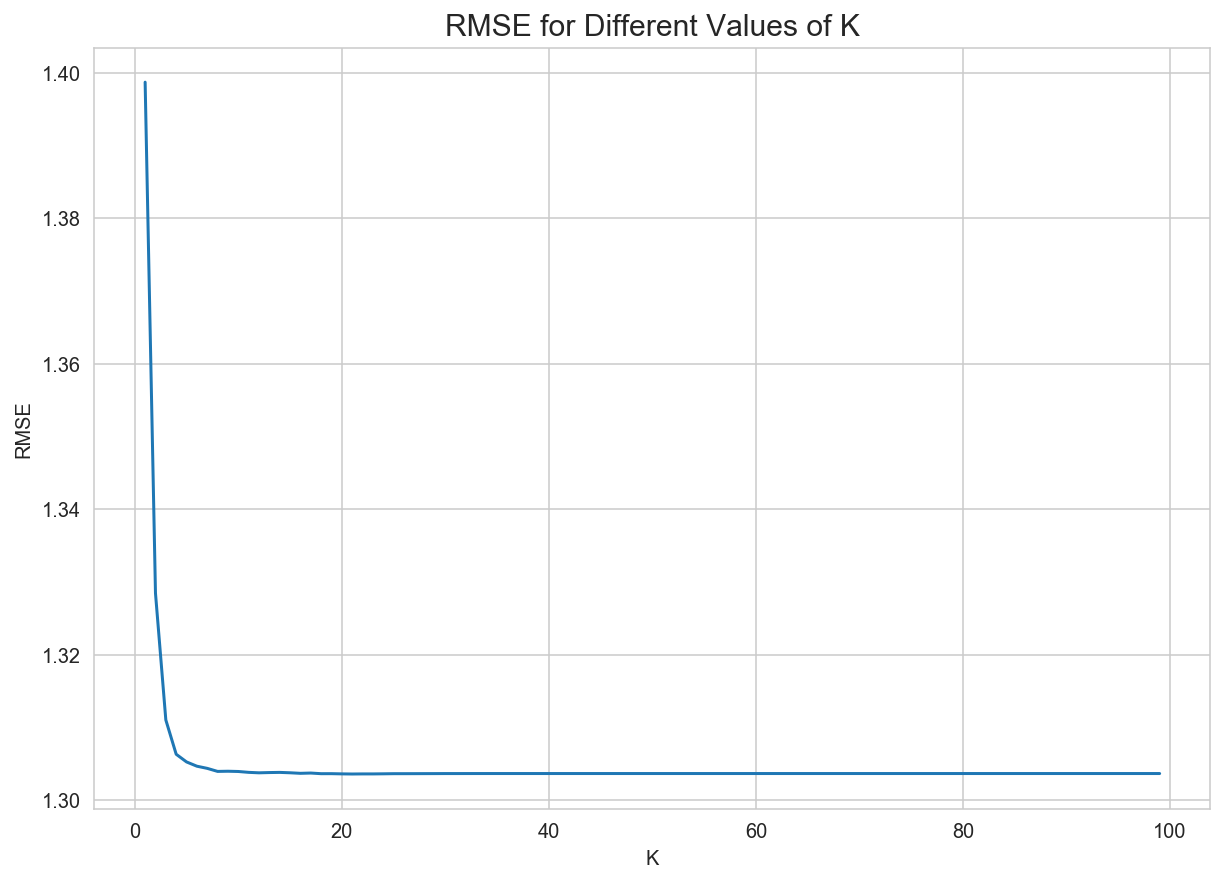

In [40]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNBasic', 
                   sim_options={'name': 'msd', 'user_based': False})

In [41]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
20,21,1.303584
22,23,1.303597
21,22,1.303597
19,20,1.303602
23,24,1.303611


In [42]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNBasic(k=best_k, sim_options={'name': 'msd', 'user_based': False})
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


### 2.A.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [43]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [44]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 10345078):
                                        product_title  star_rating
1621                            God of War: Ascension            5
4031                   Mortal Kombat Komplete Edition            5
5094                   Uncharted 3: Drake's Deception            5
5568     Batman: Arkham City Game of the Year Edition            5
7888                                  Resident Evil 6            5
14548      Call of Duty: Black Ops II - PlayStation 3            5
16008                      Need for Speed Most Wanted            5
17495                                    Dead Space 3            5
17997                                   Battlefield 3            5
18677                                     Max Payne 3            5
19033                   Assassin's Creed: Brotherhood            5
19200                            Assassin's Creed III            5
22727                                        LA Noire            5
23741           

In [45]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (II - KNNBasic - msd):', prec)


Precision (II - KNNBasic - msd): 0.009328694755830433


In [46]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (II - KNNBasic - MSD):', mean_ap)


MAP (II - KNNBasic - MSD): 0.09637501253640622


In [47]:
algo_2A = {'Model': 'II - KNNBasic - MSD',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [48]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNBasic',
#             sim_options={'name': 'cosine', 'user_based': False})

### 2.A.4. Make Recommendations for New Customer

In [49]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Computing the msd similarity matrix...
Done computing similarity matrix.


,items,rating
0,Battlefield 4,5.0
144,Super Smash Bros. Brawl,5.0
131,Star Wars The Old Republic,5.0
132,Mass Effect 2,5.0
134,NBA 2K14,5.0
135,Rocksmith,5.0
137,New Super Mario Bros,5.0
138,Mortal Kombat vs. DC Universe,5.0
139,Donkey Kong Country Returns,5.0
140,Super Smash Bros Melee,5.0


<br>
## 2.B. Item-Item Collaborative Filtering (KNNBasic - Pearson-baseline)

A basic collaborative filtering algorithm.

$${\normalsize \hat{r}_{ui} = \frac{\sum\limits_{j \in N^k_u(i)} \text{sim}(i, j) \cdot r_{uj}}{\sum\limits_{j \in N^k_u(i)} \text{sim}(i, j)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
${j \in N^k_u(i)}$ - $j$ items in $k$ neighborhood most similar to item $i$ for user $u$.<br>
$\text{sim}(i, j)$ - **Pearson-baseline** similarity between item $i$ and $j$.<br>
$r_{uj}$ - Rating for item $j$ and user $u$.<br>

### 2.B.1. Train Model

In [50]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNBasic(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### 2.B.2. Evaluate Model (RMSE)

In [51]:
# Evaluate test set
print("Item-based (II - KNNBasic - Pearson-baseline) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

Item-based (II - KNNBasic - Pearson-baseline) Model : Test Set
RMSE: 1.2772


**Search Best K based on RMSE**

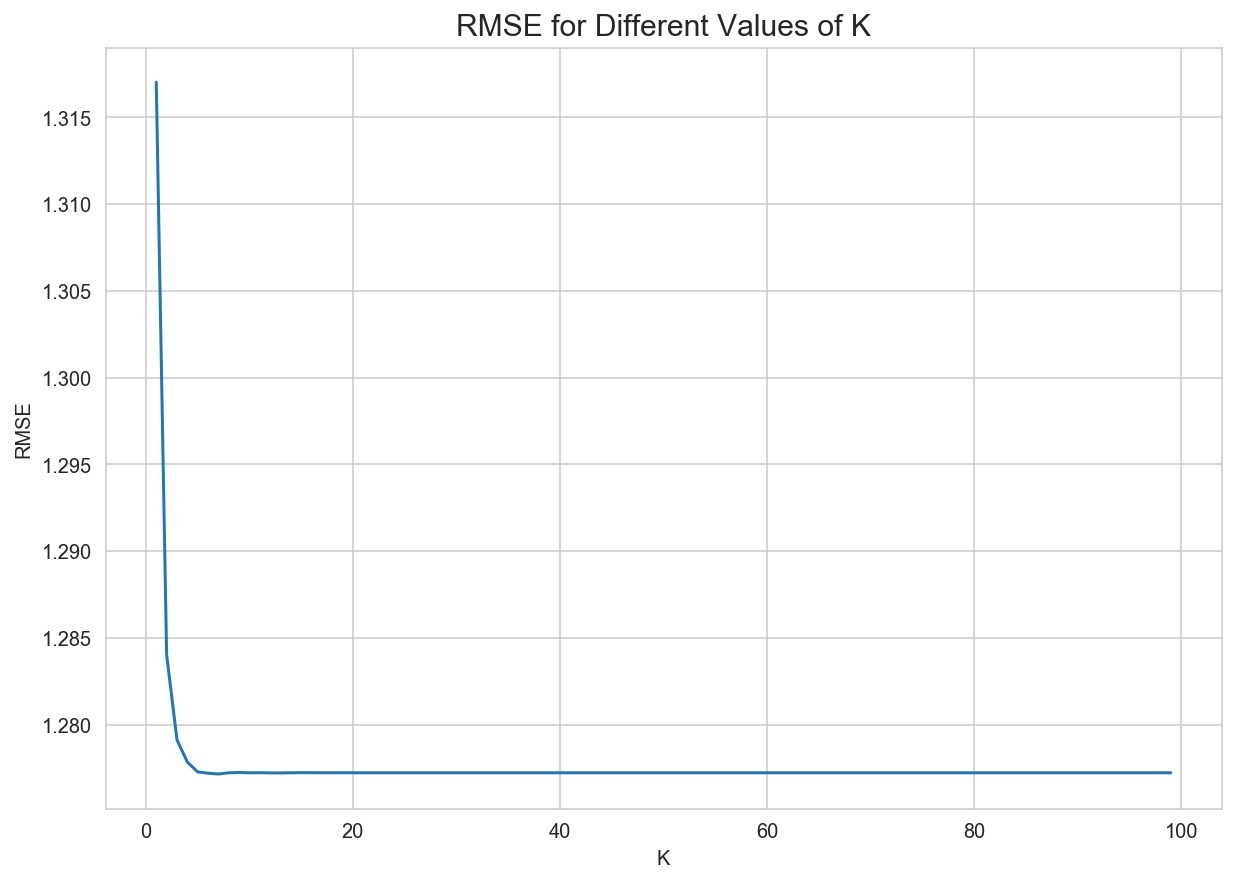

In [52]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNBasic', 
                   sim_options={'name': 'pearson_baseline', 'user_based': False})

In [53]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
6,7,1.277150
5,6,1.277197
12,13,1.277211
11,12,1.277214
9,10,1.277219


In [54]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNBasic(k=best_k, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### 2.B.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [55]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [56]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 10345078):
                                        product_title  star_rating
1621                            God of War: Ascension            5
4031                   Mortal Kombat Komplete Edition            5
5094                   Uncharted 3: Drake's Deception            5
5568     Batman: Arkham City Game of the Year Edition            5
7888                                  Resident Evil 6            5
14548      Call of Duty: Black Ops II - PlayStation 3            5
16008                      Need for Speed Most Wanted            5
17495                                    Dead Space 3            5
17997                                   Battlefield 3            5
18677                                     Max Payne 3            5
19033                   Assassin's Creed: Brotherhood            5
19200                            Assassin's Creed III            5
22727                                        LA Noire            5
23741           

In [57]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (II - KNNBasic - Pearson-baseline):', prec)


Precision (II - KNNBasic - Pearson-baseline): 0.013554954258471847


In [58]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (II - KNNBasic - Pearson-baseline):', mean_ap)


MAP (II - KNNBasic - Pearson-baseline): 0.13157920265734768


In [59]:
algo_2B = {'Model': 'II - KNNBasic - Pearson-baseline',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [60]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNBasic',
#             sim_options={'name': 'pearson', 'user_based': False})

### 2.B.4. Make Recommendations for New Customer

In [61]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


,items,rating
0,Battlefield 4,5.0
117,Call of Duty: Modern Warfare 3 - Xbox 360,5.0
109,Just Dance 2014,5.0
110,Assassin's Creed Ezio Trilogy Edition,5.0
111,Call of Duty 4: Modern Warfare,5.0
1,Far Cry 3,5.0
113,Killzone 2 - Playstation 3,5.0
114,StarCraft II,5.0
116,Super Mario Galaxy 2,5.0
118,Fallout 3: Game of The Year Edition,5.0


<br>
## 3.A. User-User Collaborative Filtering (KNNwithMeans - MSD)

A basic collaborative filtering algorithm, taking into account the mean ratings of each user.

$${\normalsize \hat{r}_{ui} = \mu_u + \frac{ \sum\limits_{v \in N^k_i(u)}\text{sim}(u, v) \cdot (r_{vi} - \mu_v)}{\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$\mu_u$ - Mean rating for user $u$.<br>
${v \in N^k_i(u)}$ - $v$ users in $k$ neighborhood most similar to user $u$ for item $i$.<br>
$\text{sim}(u, v)$ - **MSD** similarity between user $u$ and $v$.<br>
$(r_{vi} - \mu_v)$ - Deviation of rating for user $v$ and its mean rating.<br>

### 3.A.1. Train Model

In [62]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNWithMeans(k=50, sim_options={'name': 'msd', 'user_based': True})
algo.fit(trainset)


Computing the msd similarity matrix...
Done computing similarity matrix.


### 3.A.2. Evaluate Model (RMSE)

In [63]:
# Evaluate test set
print("User-based (UU - KNNwithMeans - MSD) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

User-based (UU - KNNwithMeans - MSD) Model : Test Set
RMSE: 1.2786


**Search Best K based on RMSE**

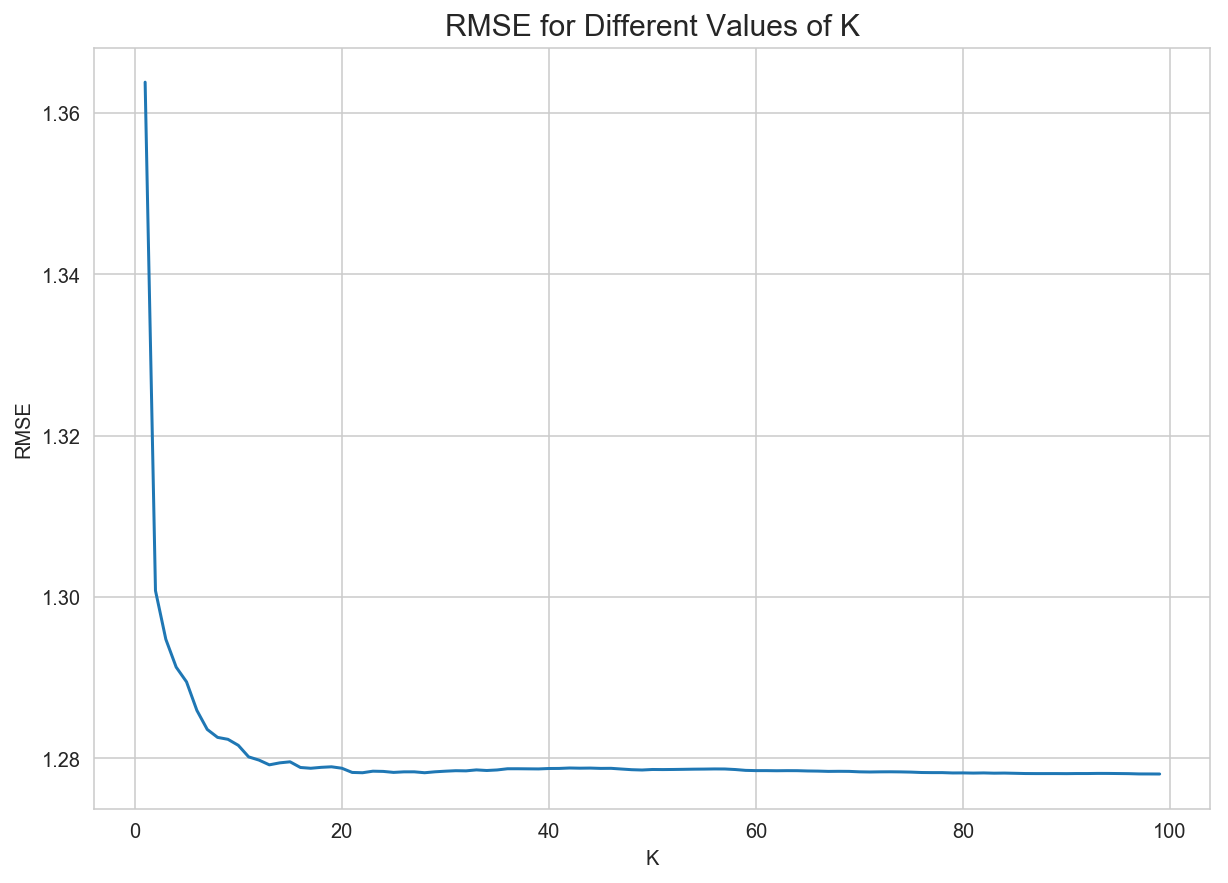

In [64]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNWithMeans', 
                   sim_options={'name': 'msd', 'user_based': True})

In [65]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(2)

,k,test_rmse
98,99,1.278068
97,98,1.278074


In [66]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNWithMeans(k=best_k, sim_options={'name': 'msd', 'user_based': True})
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


### 3.A.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [67]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [68]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 10345078):
                                        product_title  star_rating
1621                            God of War: Ascension            5
4031                   Mortal Kombat Komplete Edition            5
5094                   Uncharted 3: Drake's Deception            5
5568     Batman: Arkham City Game of the Year Edition            5
7888                                  Resident Evil 6            5
14548      Call of Duty: Black Ops II - PlayStation 3            5
16008                      Need for Speed Most Wanted            5
17495                                    Dead Space 3            5
17997                                   Battlefield 3            5
18677                                     Max Payne 3            5
19033                   Assassin's Creed: Brotherhood            5
19200                            Assassin's Creed III            5
22727                                        LA Noire            5
23741           

In [69]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (UU - KNNwithMeans - MSD):', prec)


Precision (UU - KNNwithMeans - MSD): 0.008864837005540525


In [70]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (UU - KNNwithMeans - MSD):', mean_ap)


MAP (UU - KNNwithMeans - MSD): 0.08496186940936296


In [71]:
algo_3A = {'Model': 'UU - KNNwithMeans - MSD',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [72]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNWithMeans',
#             sim_options={'name': 'cosine', 'user_based': True})

### 3.A.4. Make Recommendations for New Customer

In [73]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Computing the msd similarity matrix...
Done computing similarity matrix.


,items,rating
112,Killzone 3,5.0
81,Mario Kart 7,5.0
129,Carnival Games,5.0
132,Mass Effect 2,5.0
136,God of War III,5.0
140,Super Smash Bros Melee,5.0
141,Michael Jackson The Experience,5.0
142,Mario Kart DS,5.0
143,Mario Kart: Double Dash,5.0
144,Super Smash Bros. Brawl,5.0


<br>
## 3.B. User-User Collaborative Filtering (KNNwithMeans - Pearson-baseline)

A basic collaborative filtering algorithm, taking into account the mean ratings of each user.

$${\normalsize \hat{r}_{ui} = \mu_u + \frac{ \sum\limits_{v \in N^k_i(u)}\text{sim}(u, v) \cdot (r_{vi} - \mu_v)}{\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$\mu_u$ - Mean rating for user $u$.<br>
${v \in N^k_i(u)}$ - $v$ users in $k$ neighborhood most similar to user $u$ for item $i$.<br>
$\text{sim}(u, v)$ - **Pearson-baseline** similarity between user $u$ and $v$.<br>
$(r_{vi} - \mu_v)$ - Deviation of rating for user $v$ and its mean rating.<br>

### 3.B.1. Train Model

In [74]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### 3.B.2. Evaluate Model (RMSE)

In [75]:
# Evaluate test set
print("User-based (UU - KNNwithMeans - Pearson-baseline) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

User-based (UU - KNNwithMeans - Pearson-baseline) Model : Test Set
RMSE: 1.3409


**Search Best K based on RMSE**

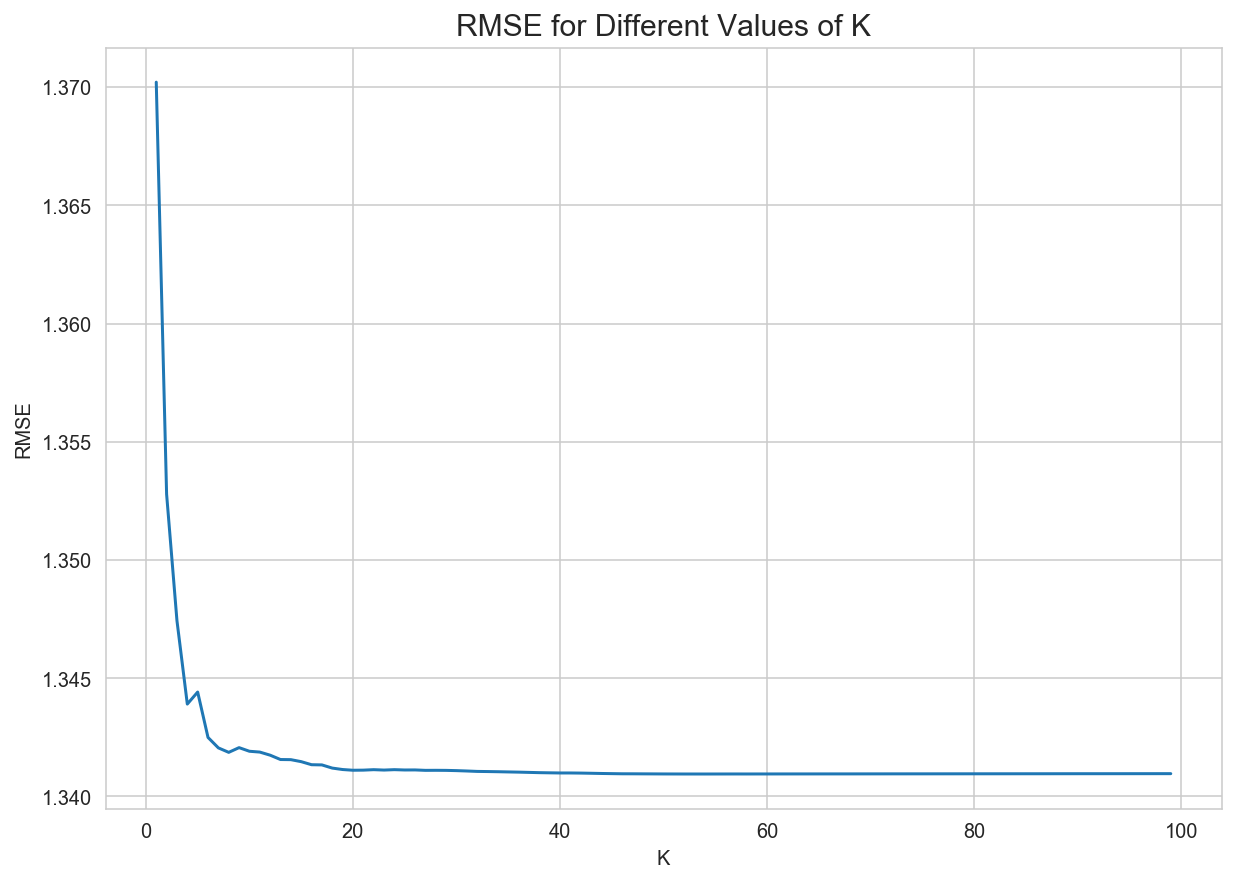

In [76]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNWithMeans', 
                   sim_options={'name': 'pearson_baseline', 'user_based': True})

In [77]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(2)

,k,test_rmse
53,54,1.340946
52,53,1.340946


In [78]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNWithMeans(k=best_k, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### 3.B.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [79]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [80]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 10345078):
                                        product_title  star_rating
1621                            God of War: Ascension            5
4031                   Mortal Kombat Komplete Edition            5
5094                   Uncharted 3: Drake's Deception            5
5568     Batman: Arkham City Game of the Year Edition            5
7888                                  Resident Evil 6            5
14548      Call of Duty: Black Ops II - PlayStation 3            5
16008                      Need for Speed Most Wanted            5
17495                                    Dead Space 3            5
17997                                   Battlefield 3            5
18677                                     Max Payne 3            5
19033                   Assassin's Creed: Brotherhood            5
19200                            Assassin's Creed III            5
22727                                        LA Noire            5
23741           

In [81]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (UU - KNNwithMeans - Pearson-baseline):')


Precision (UU - KNNwithMeans - Pearson-baseline):


In [82]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (UU - KNNwithMeans - Pearson-baseline):')


MAP (UU - KNNwithMeans - Pearson-baseline):


In [83]:
algo_3B = {'Model': 'UU - KNNwithMeans - Pearson-baseline',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [84]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNWithMeans',
#             sim_options={'name': 'pearson', 'user_based': True})

### 3.B.4. Make Recommendations for New Customer

In [85]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


,items,rating
112,Killzone 3,5.0
147,Uncharted 2: Among Thieves - Playstation 3,5.0
136,God of War III,5.0
137,New Super Mario Bros,5.0
139,Donkey Kong Country Returns,5.0
140,Super Smash Bros Melee,5.0
141,Michael Jackson The Experience,5.0
142,Mario Kart DS,5.0
143,Mario Kart: Double Dash,5.0
145,Super Mario Galaxy (Nintendo Selects),5.0


<br>
## 4.A. Item-Item Collaborative Filtering (KNNwithMeans - MSD)

A basic collaborative filtering algorithm, taking into account the mean ratings of each user.

$${\normalsize \hat{r}_{ui} = \mu_i + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - \mu_j)} {\sum\limits_{j \in N^k_u(i)} \text{sim}(i, j)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$\mu_i$ - Mean rating for item $i$.<br>
${j \in N^k_u(i)}$ - $j$ items in $k$ neighborhood most similar to item $i$ for user $u$.<br>
$\text{sim}(i, j)$ - **MSD** similarity between item $i$ and $j$.<br>
$(r_{uj} - \mu_j)$ - Deviation of rating for item $j$ and their mean rating.<br>

### 4.A.1. Train Model

In [86]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNWithMeans(k=50, sim_options={'name': 'msd', 'user_based': False})
algo.fit(trainset)


Computing the msd similarity matrix...
Done computing similarity matrix.


### 4.A.2. Evaluate Model (RMSE)

In [87]:
# Evaluate test set
print("Item-based (II - KNNwithMeans - MSD) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

Item-based (II - KNNwithMeans - MSD) Model : Test Set
RMSE: 1.2307


**Search Best K based on RMSE**

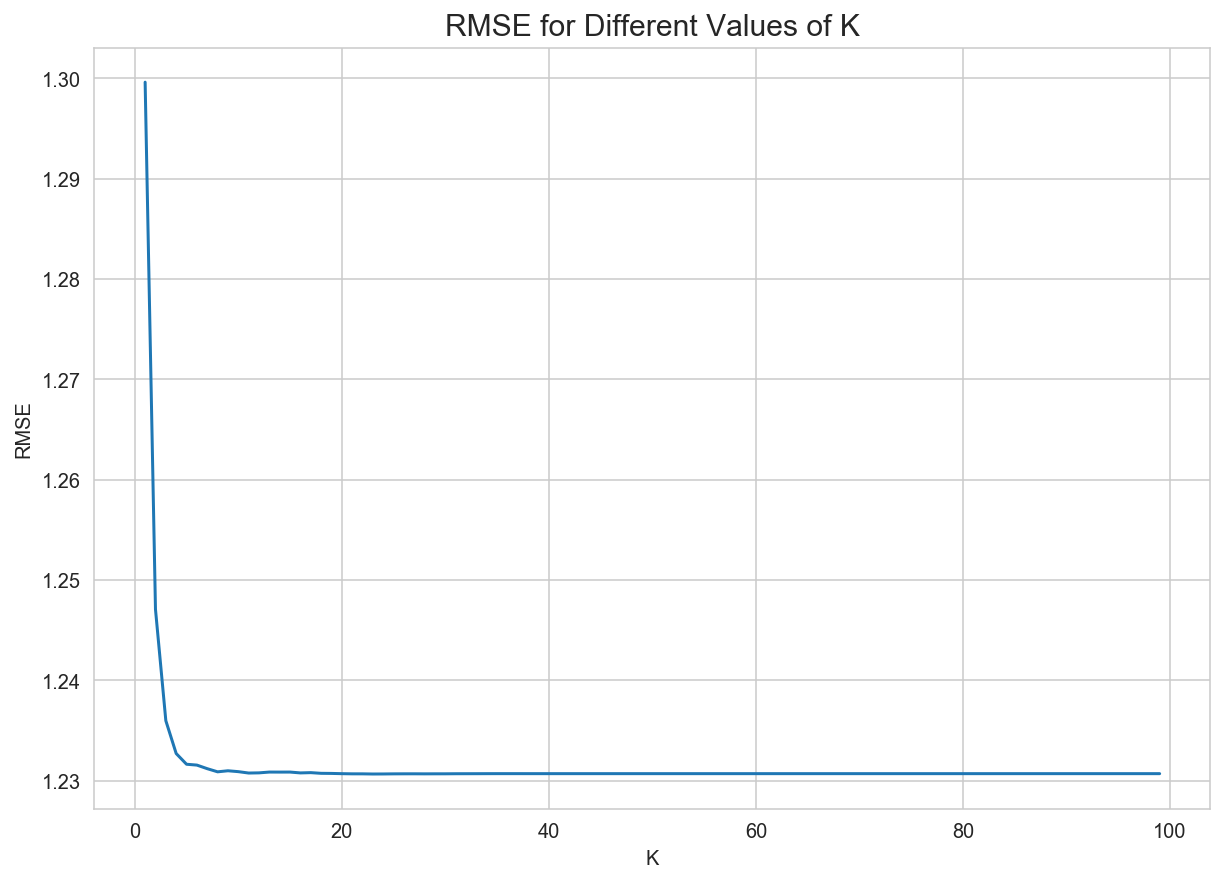

In [88]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNWithMeans', 
                   sim_options={'name': 'msd', 'user_based': False})

In [89]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
22,23,1.230665
23,24,1.230669
24,25,1.230680
27,28,1.230680
21,22,1.230681


In [90]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNWithMeans(k=best_k, sim_options={'name': 'msd', 'user_based': False})
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


### 4.A.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [91]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [92]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 10345078):
                                        product_title  star_rating
1621                            God of War: Ascension            5
4031                   Mortal Kombat Komplete Edition            5
5094                   Uncharted 3: Drake's Deception            5
5568     Batman: Arkham City Game of the Year Edition            5
7888                                  Resident Evil 6            5
14548      Call of Duty: Black Ops II - PlayStation 3            5
16008                      Need for Speed Most Wanted            5
17495                                    Dead Space 3            5
17997                                   Battlefield 3            5
18677                                     Max Payne 3            5
19033                   Assassin's Creed: Brotherhood            5
19200                            Assassin's Creed III            5
22727                                        LA Noire            5
23741           

In [93]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (II - KNNwithMeans - MSD):', prec)


Precision (II - KNNwithMeans - MSD): 0.009689473006055922


In [94]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (II - KNNwithMeans - MSD):', mean_ap)


MAP (II - KNNwithMeans - MSD): 0.10031884266896757


In [95]:
algo_4A = {'Model': 'II - KNNwithMeans - MSD',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [96]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNWithMeans',
#             sim_options={'name': 'cosine', 'user_based': False})

### 4.A.4. Make Recommendations for New Customer

In [97]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Computing the msd similarity matrix...
Done computing similarity matrix.


,items,rating
112,Killzone 3,5.0
143,Mario Kart: Double Dash,5.0
132,Mass Effect 2,5.0
133,PlayStation All-Stars Battle Royale,5.0
135,Rocksmith,5.0
136,God of War III,5.0
137,New Super Mario Bros,5.0
138,Mortal Kombat vs. DC Universe,5.0
139,Donkey Kong Country Returns,5.0
140,Super Smash Bros Melee,5.0


<br>
## 4.B. Item-Item Collaborative Filtering (KNNwithMeans - Pearson-baseline)

A basic collaborative filtering algorithm, taking into account the mean ratings of each user.

$${\normalsize \hat{r}_{ui} = \mu_i + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - \mu_j)} {\sum\limits_{j \in N^k_u(i)} \text{sim}(i, j)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$\mu_i$ - Mean rating for item $i$.<br>
${j \in N^k_u(i)}$ - $j$ items in $k$ neighborhood most similar to item $i$ for user $u$.<br>
$\text{sim}(i, j)$ - **Pearson-baseline** similarity between item $i$ and $j$.<br>
$(r_{uj} - \mu_j)$ - Deviation of rating for item $j$ and their mean rating.<br>

### 4.B.1. Train Model

In [98]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### 4.B.2. Evaluate Model (RMSE)

In [99]:
# Evaluate test set
print("Item-based (II - KNNwithMeans - Pearson-baseline) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

Item-based (II - KNNwithMeans - Pearson-baseline) Model : Test Set
RMSE: 1.2151


**Search Best K based on RMSE**

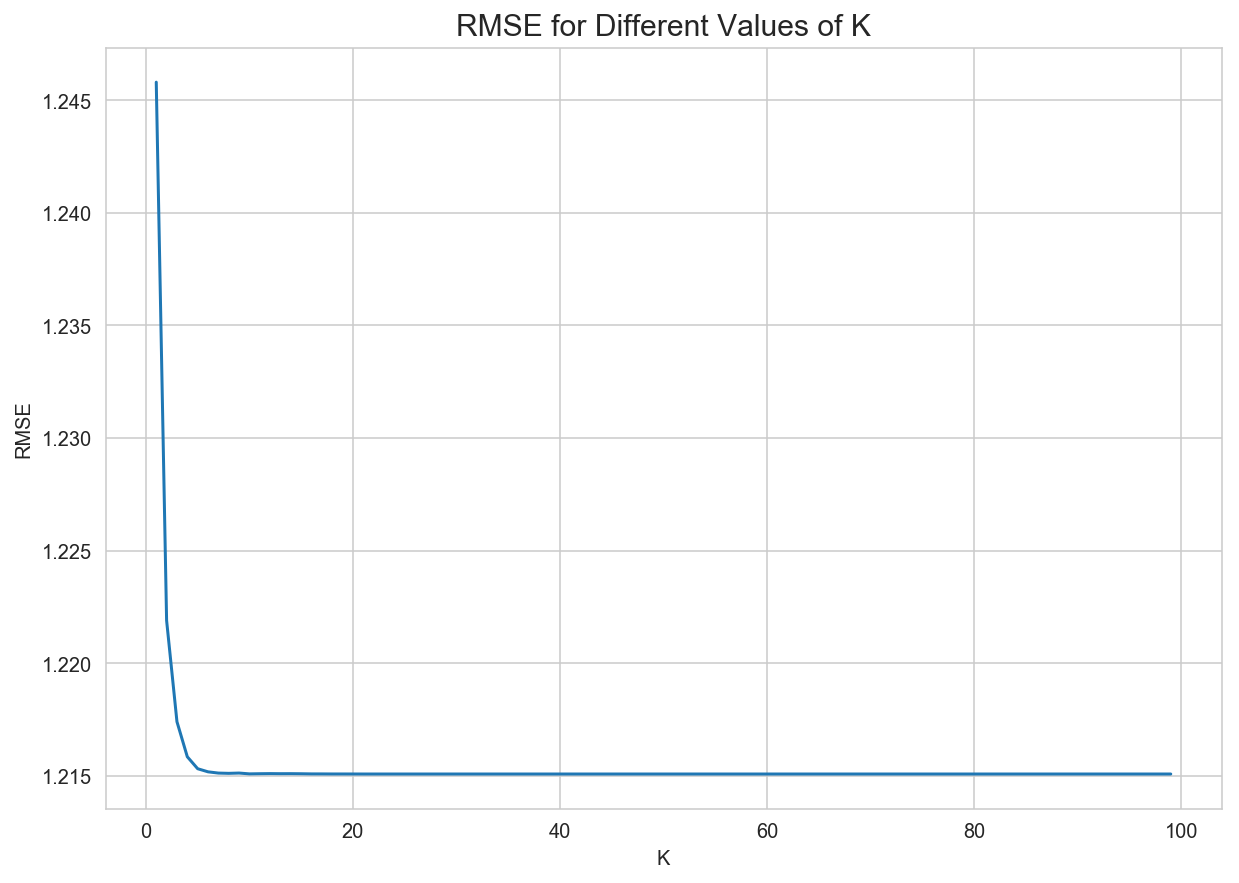

In [100]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNWithMeans', 
                   sim_options={'name': 'pearson_baseline', 'user_based': False})

In [101]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
49,50,1.215083
71,72,1.215083
70,71,1.215083
69,70,1.215083
68,69,1.215083


In [102]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNWithMeans(k=best_k, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### 4.B.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [103]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [104]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 10345078):
                                        product_title  star_rating
1621                            God of War: Ascension            5
4031                   Mortal Kombat Komplete Edition            5
5094                   Uncharted 3: Drake's Deception            5
5568     Batman: Arkham City Game of the Year Edition            5
7888                                  Resident Evil 6            5
14548      Call of Duty: Black Ops II - PlayStation 3            5
16008                      Need for Speed Most Wanted            5
17495                                    Dead Space 3            5
17997                                   Battlefield 3            5
18677                                     Max Payne 3            5
19033                   Assassin's Creed: Brotherhood            5
19200                            Assassin's Creed III            5
22727                                        LA Noire            5
23741           

In [105]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (II - KNNwithMeans - Pearson-baseline):', prec)


Precision (II - KNNwithMeans - Pearson-baseline): 0.011596443757247778


In [106]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (II - KNNwithMeans - Pearson-baseline):', mean_ap)


MAP (II - KNNwithMeans - Pearson-baseline): 0.1189232436472121


In [107]:
algo_4B = {'Model': 'II - KNNwithMeans - Pearson-baseline',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [108]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNWithMeans',
#             sim_options={'name': 'pearson', 'user_based': False})

### 4.B.4. Make Recommendations for New Customer

In [109]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


,items,rating
112,Killzone 3,5.0
171,Madden NFL 25 Anniversary Edition with NFL Sun...,5.0
92,The Elder Scrolls V: Skyrim Legendary Edition,5.0
93,Halo 3: ODST,5.0
94,Call of Duty: World at War,5.0
97,Medal of Honor: Allied Assault - PC,5.0
98,Fallout 3,5.0
99,God Of War Collection,5.0
101,Borderlands,5.0
177,Forza Horizon,5.0


<br>
## 5.A. User-User Collaborative Filtering (KNNBaseline - MSD)

A basic collaborative filtering algorithm taking into account a *baseline* rating.

$${\normalsize \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$b_{ui}$ - Baseline estimate for user $u$ and item $i$.<br>
${v \in N^k_u(i)}$ - $v$ users in $k$ neighborhood most similar to user $u$ for item $i$.<br>
$\text{sim}(u, v)$ - **MSD** similarity between user $u$ and $v$.<br>
$(r_{vi} - b_{vi})$ - Deviation of rating for user $u$ item $i$ and its baseline estimate.<br>

### 5.A.1. Train Model

In [110]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNBaseline(k=50, sim_options={'name': 'msd', 'user_based': True})
algo.fit(trainset)


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


### 5.A.2. Evaluate Model (RMSE)

In [111]:
# Evaluate test set
print("User-based (UU - KNNBaseline - MSD) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

User-based (UU - KNNBaseline - MSD) Model : Test Set
RMSE: 1.2126


**Search Best K based on RMSE**

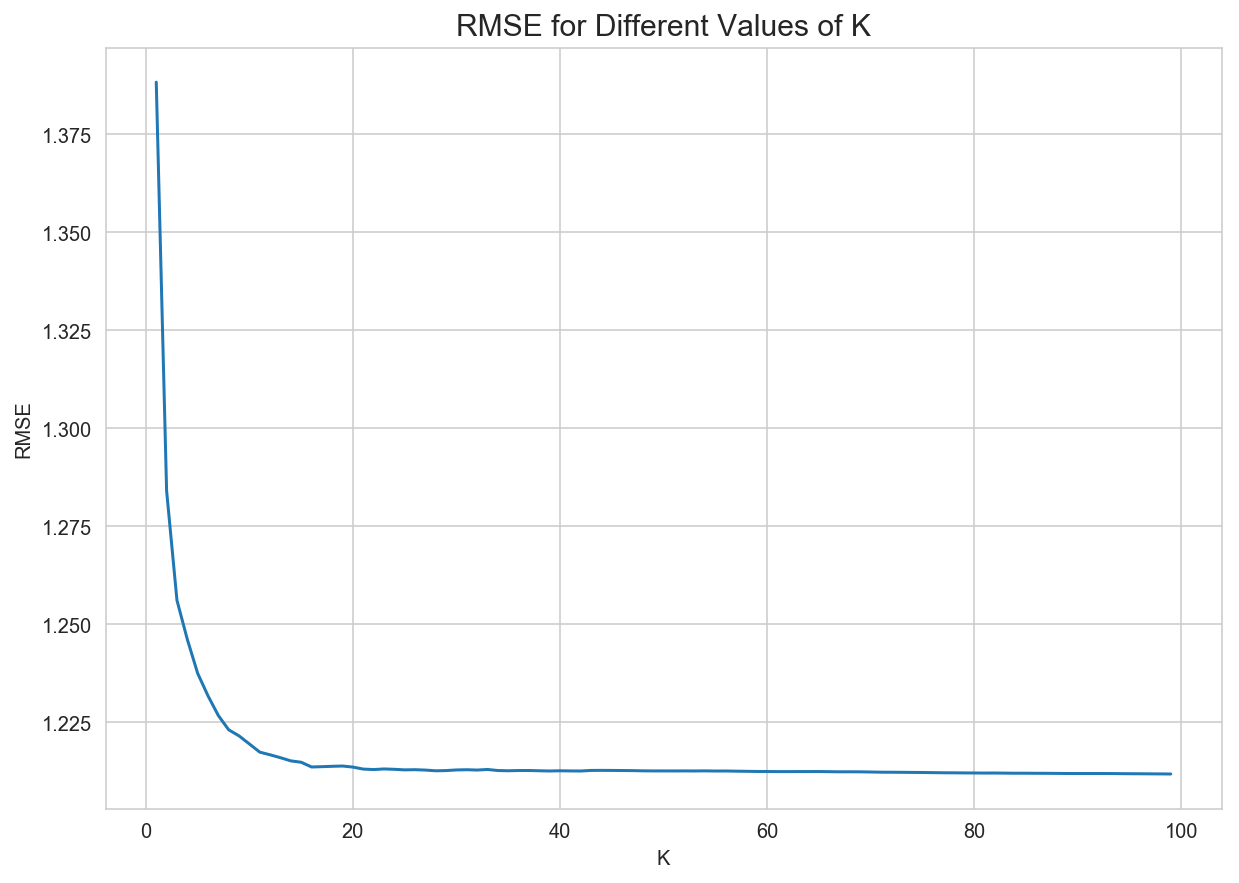

In [112]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNBaseline', 
                   sim_options={'name': 'msd', 'user_based': True})

In [113]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
98,99,1.211784
97,98,1.211808
96,97,1.211824
95,96,1.211846
94,95,1.211858


In [114]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNBaseline(k=best_k, sim_options={'name': 'msd', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


### 5.A.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [115]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [116]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 10345078):
                                        product_title  star_rating
1621                            God of War: Ascension            5
4031                   Mortal Kombat Komplete Edition            5
5094                   Uncharted 3: Drake's Deception            5
5568     Batman: Arkham City Game of the Year Edition            5
7888                                  Resident Evil 6            5
14548      Call of Duty: Black Ops II - PlayStation 3            5
16008                      Need for Speed Most Wanted            5
17495                                    Dead Space 3            5
17997                                   Battlefield 3            5
18677                                     Max Payne 3            5
19033                   Assassin's Creed: Brotherhood            5
19200                            Assassin's Creed III            5
22727                                        LA Noire            5
23741           

In [117]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (UU - KNNBaseline - MSD):', prec)


Precision (UU - KNNBaseline - MSD): 0.005231284628269553


In [118]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (UU - KNNBaseline - MSD):', mean_ap)


MAP (UU - KNNBaseline - MSD): 0.05329418645946331


In [119]:
algo_5A = {'Model': 'II - KNNBaseline - MSD',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [120]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNBaseline',
#             sim_options={'name': 'cosine', 'user_based': True})

### 5.A.4. Make Recommendations for New Customer

In [121]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


,items,rating
218,Animal Crossing: Wild World,5.0
27,Call of Duty: Ghosts,5.0
97,Medal of Honor: Allied Assault - PC,5.0
65,Metal Gear Solid 2: Sons of Liberty,5.0
72,Metroid: Other M,5.0
219,Roller Coaster Tycoon,5.0
20,The Legend of Zelda: Twilight Princess,5.0
128,Lego Star Wars: The Complete Saga,5.0
123,Dance Central 2 - Xbox 360,5.0
142,Mario Kart DS,5.0


<br>
## 5.B. User-User Collaborative Filtering (KNNBaseline - Pearson-baseline)

A basic collaborative filtering algorithm taking into account a *baseline* rating.

$${\normalsize \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$b_{ui}$ - Baseline estimate for user $u$ and item $i$.<br>
${v \in N^k_u(i)}$ - $v$ users in $k$ neighborhood most similar to user $u$ for item $i$.<br>
$\text{sim}(u, v)$ - **Pearson-baseline** similarity between user $u$ and $v$.<br>
$(r_{vi} - b_{vi})$ - Deviation of rating for user $u$ item $i$ and its baseline estimate.<br>

### 5.B.1. Train Model

In [122]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNBaseline(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### 5.B.2. Evaluate Model (RMSE)

In [123]:
# Evaluate test set
print("User-based (UU - KNNBaseline - Pearson-baseline) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

User-based (UU - KNNBaseline - Pearson-baseline) Model : Test Set
RMSE: 1.2253


**Search Best K based on RMSE**

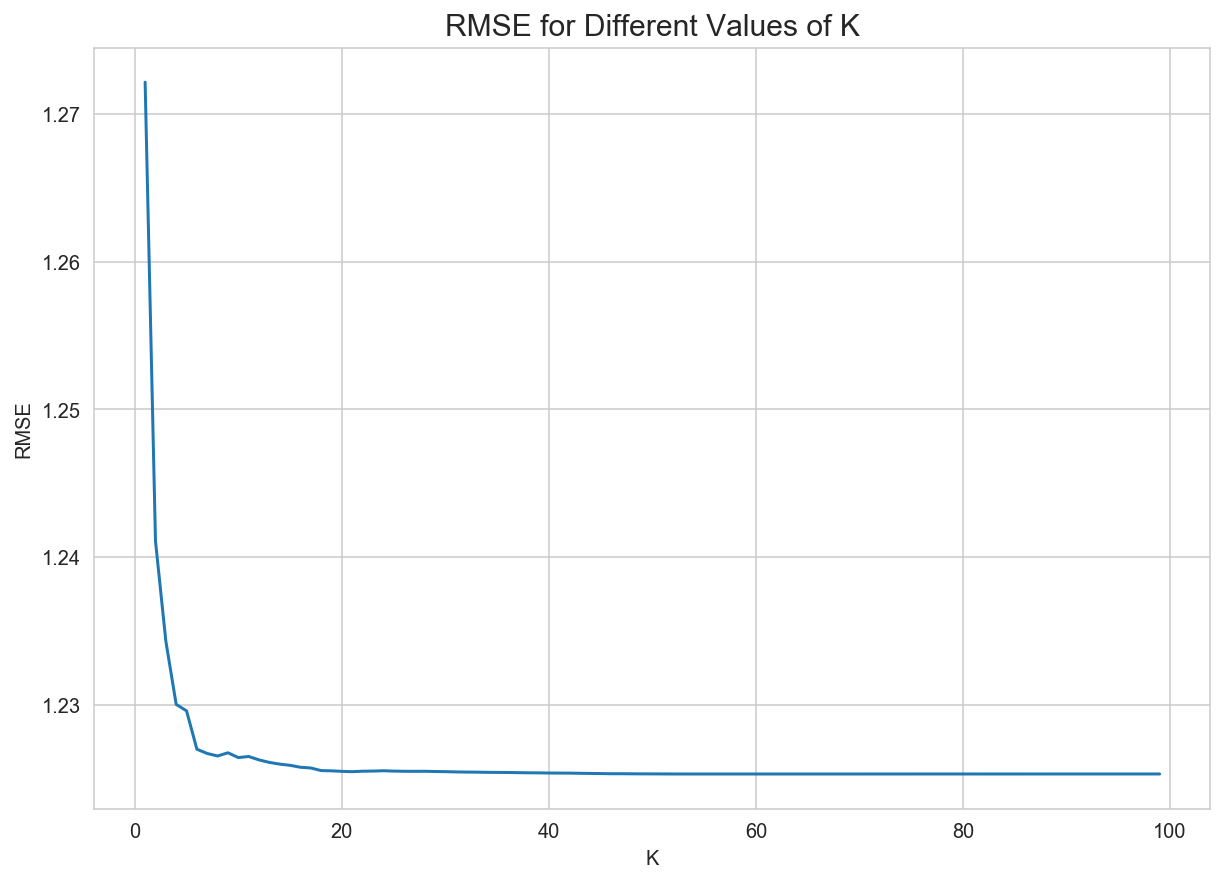

In [124]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNBaseline', 
                   sim_options={'name': 'pearson_baseline', 'user_based': True})

In [125]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
59,60,1.225307
54,55,1.225307
57,58,1.225307
60,61,1.225307
62,63,1.225307


In [126]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNBaseline(k=best_k, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### 5.B.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [127]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [128]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 10345078):
                                        product_title  star_rating
1621                            God of War: Ascension            5
4031                   Mortal Kombat Komplete Edition            5
5094                   Uncharted 3: Drake's Deception            5
5568     Batman: Arkham City Game of the Year Edition            5
7888                                  Resident Evil 6            5
14548      Call of Duty: Black Ops II - PlayStation 3            5
16008                      Need for Speed Most Wanted            5
17495                                    Dead Space 3            5
17997                                   Battlefield 3            5
18677                                     Max Payne 3            5
19033                   Assassin's Creed: Brotherhood            5
19200                            Assassin's Creed III            5
22727                                        LA Noire            5
23741           

In [129]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (UU - KNNBaseline - Pearson-baseline):', prec)


Precision (UU - KNNBaseline - Pearson-baseline): 0.011081046256925655


In [130]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (UU - KNNBaseline - Pearson-baseline):', mean_ap)


MAP (UU - KNNBaseline - Pearson-baseline): 0.10831140760620517


In [131]:
algo_5B = {'Model': 'UU - KNNBaseline - Pearson-baseline',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [132]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNBaseline',
#             sim_options={'name': 'pearson', 'user_based': True})

### 5.B.4. Make Recommendations for New Customer

In [133]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


,items,rating
33,Metal Gear Solid 4: Guns of the Patriots,5.0
218,Animal Crossing: Wild World,5.0
205,Grand Theft Auto: San Andreas,5.0
108,Red Dead Redemption,5.0
103,Mass Effect - Xbox 360 (Limited),5.0
35,LittleBigPlanet,5.0
198,FIFA Soccer 13,5.0
146,Super Mario 64,5.0
147,Uncharted 2: Among Thieves - Playstation 3,5.0
99,God Of War Collection,5.0


<br>
## 6.A. Item-Item Collaborative Filtering (KNNBaseline - MSD)

A basic collaborative filtering algorithm taking into account a *baseline* rating.

$${\normalsize \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in N^k_u(i)} \text{sim}(i, j)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$b_{ui}$ - Baseline estimate for user $u$ and item $i$.<br>
${j \in N^k_u(i)}$ - $j$ items in $k$ neighborhood most similar to item $i$ for user $u$.<br>
$\text{sim}(i, j)$ - **MSD** similarity between items $i$ and $j$.<br>
$(r_{uj} - b_{uj})$ - Deviation of rating for user $u$ item $j$ and its baseline estimate.<br>

### 6.A.1. Train Model

In [134]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNBaseline(k=50, sim_options={'name': 'msd', 'user_based': False})
algo.fit(trainset)


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


### 6.A.2. Evaluate Model (RMSE)

In [135]:
# Evaluate test set
print("Item-based (II - KNNBaseline - MSD) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

Item-based (II - KNNBaseline - MSD) Model : Test Set
RMSE: 1.2275


**Search Best K based on RMSE**

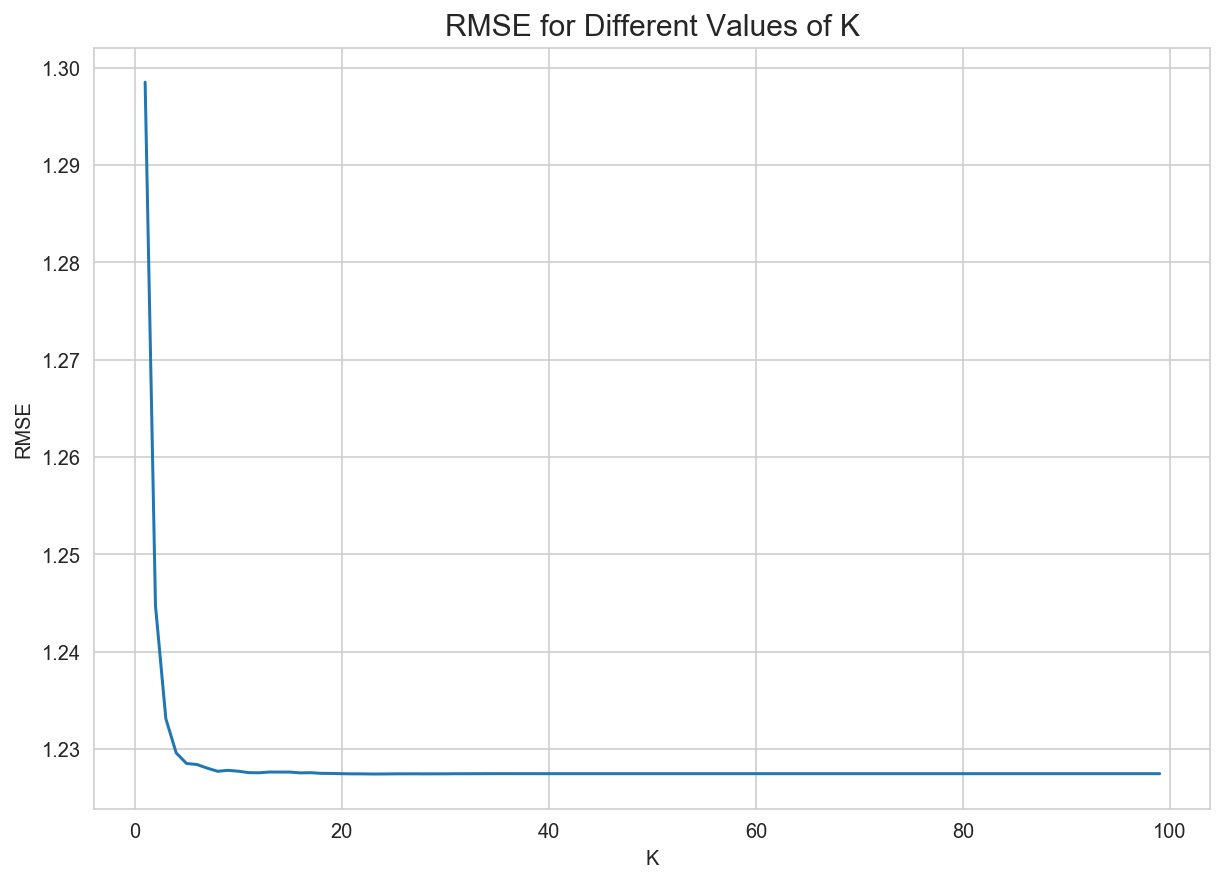

In [136]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNBaseline', 
                   sim_options={'name': 'msd', 'user_based': False})

In [137]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
22,23,1.227432
23,24,1.227437
21,22,1.227447
24,25,1.227448
20,21,1.227448


In [138]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNBaseline(k=best_k, sim_options={'name': 'msd', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


### 6.A.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [139]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [140]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 10345078):
                                        product_title  star_rating
1621                            God of War: Ascension            5
4031                   Mortal Kombat Komplete Edition            5
5094                   Uncharted 3: Drake's Deception            5
5568     Batman: Arkham City Game of the Year Edition            5
7888                                  Resident Evil 6            5
14548      Call of Duty: Black Ops II - PlayStation 3            5
16008                      Need for Speed Most Wanted            5
17495                                    Dead Space 3            5
17997                                   Battlefield 3            5
18677                                     Max Payne 3            5
19033                   Assassin's Creed: Brotherhood            5
19200                            Assassin's Creed III            5
22727                                        LA Noire            5
23741           

In [141]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (II - KNNBaseline - MSD):', prec)


Precision (II - KNNBaseline - MSD): 0.011338745007086717


In [142]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (II - KNNBaseline - MSD):', mean_ap)


MAP (II - KNNBaseline - MSD): 0.11644231285564478


In [143]:
algo_6A = {'Model': 'II - KNNBaseline - MSD',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [144]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNBaseline',
#             sim_options={'name': 'cosine', 'user_based': False})

### 6.A.4. Make Recommendations for New Customer

In [145]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


,items,rating
112,Killzone 3,5.0
96,Kingdom Hearts II - PlayStation 2,5.0
133,PlayStation All-Stars Battle Royale,5.0
135,Rocksmith,5.0
136,God of War III,5.0
137,New Super Mario Bros,5.0
138,Mortal Kombat vs. DC Universe,5.0
139,Donkey Kong Country Returns,5.0
140,Super Smash Bros Melee,5.0
142,Mario Kart DS,5.0


<br>
## 6.B. Item-Item Collaborative Filtering (KNNBaseline - Pearson-baseline)

A basic collaborative filtering algorithm taking into account a *baseline* rating.

$${\normalsize \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in N^k_u(i)} \text{sim}(i, j)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$b_{ui}$ - Baseline estimate for user $u$ and item $i$.<br>
${j \in N^k_u(i)}$ - $j$ items in $k$ neighborhood most similar to item $i$ for user $u$.<br>
$\text{sim}(i, j)$ - **Pearson-baseline** similarity between items $i$ and $j$.<br>
$(r_{uj} - b_{uj})$ - Deviation of rating for user $u$ item $j$ and its baseline estimate.<br>

### 6.B.1. Train Model

In [146]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNBaseline(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### 6.B.2. Evaluate Model (RMSE)

In [147]:
# Evaluate test set
print("Item-based (KNNBaseline - Pearson-baseline) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

Item-based (KNNBaseline - Pearson-baseline) Model : Test Set
RMSE: 1.2063


**Search Best K based on RMSE**

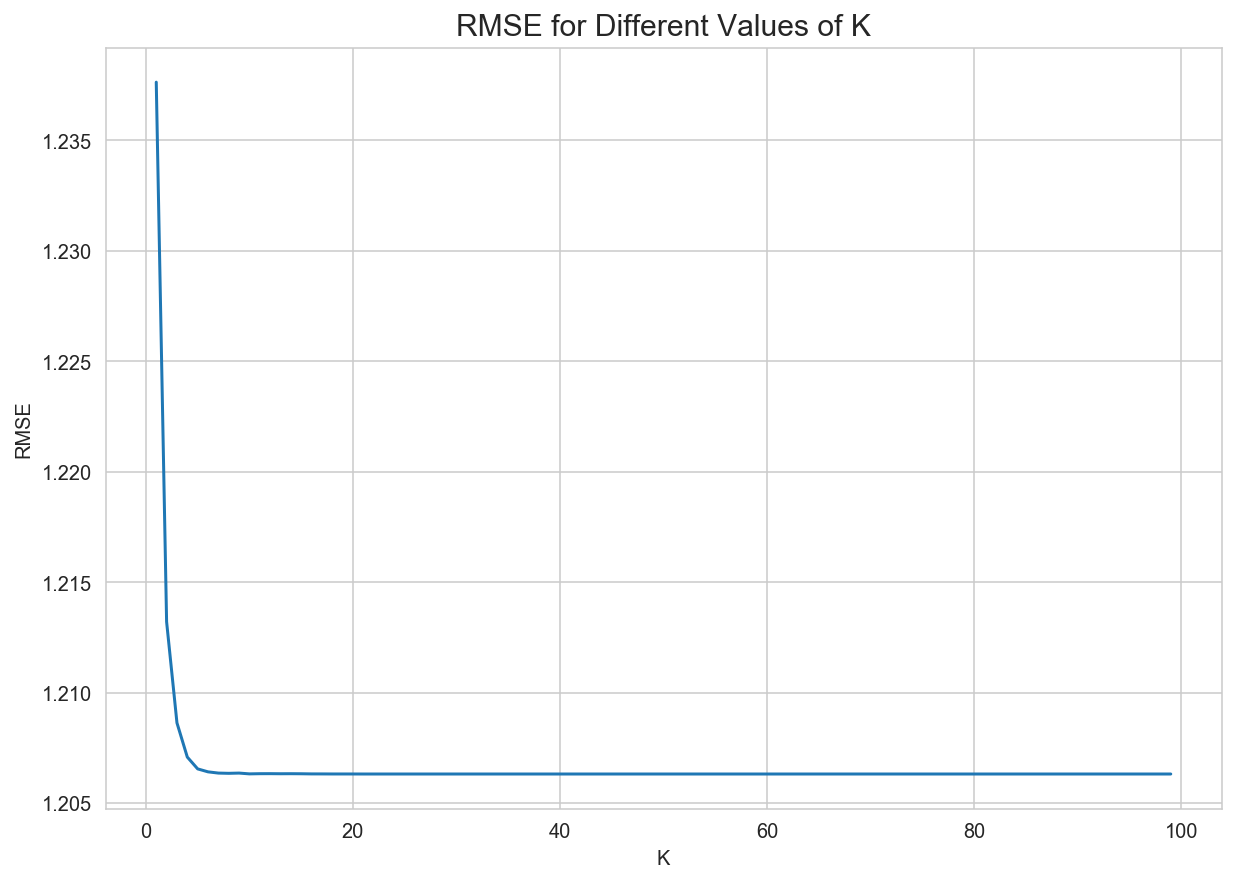

In [148]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNBaseline', 
                   sim_options={'name': 'pearson_baseline', 'user_based': False})

In [149]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
49,50,1.206316
71,72,1.206316
70,71,1.206316
69,70,1.206316
68,69,1.206316


In [150]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNBaseline(k=best_k, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### 6.B.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [151]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [152]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 10345078):
                                        product_title  star_rating
1621                            God of War: Ascension            5
4031                   Mortal Kombat Komplete Edition            5
5094                   Uncharted 3: Drake's Deception            5
5568     Batman: Arkham City Game of the Year Edition            5
7888                                  Resident Evil 6            5
14548      Call of Duty: Black Ops II - PlayStation 3            5
16008                      Need for Speed Most Wanted            5
17495                                    Dead Space 3            5
17997                                   Battlefield 3            5
18677                                     Max Payne 3            5
19033                   Assassin's Creed: Brotherhood            5
19200                            Assassin's Creed III            5
22727                                        LA Noire            5
23741           

In [153]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (II - KNNBaseline - Pearson-baseline):', prec)


Precision (II - KNNBaseline - Pearson-baseline): 0.013967272258729546


In [154]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (II - KNNBaseline - Pearson-baseline):', mean_ap)


MAP (II - KNNBaseline - Pearson-baseline): 0.1410182450404906


In [155]:
algo_6B = {'Model': 'II - KNNBaseline - Pearson-baseline',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [156]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNBaseline',
#             sim_options={'name': 'cosine', 'user_based': False})

### 6.B.4. Make Recommendations for New Customer

In [157]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


,items,rating
112,Killzone 3,5.0
101,Borderlands,5.0
92,The Elder Scrolls V: Skyrim Legendary Edition,5.0
93,Halo 3: ODST,5.0
94,Call of Duty: World at War,5.0
98,Fallout 3,5.0
99,God Of War Collection,5.0
166,Dragon Age 2,5.0
165,Kingdoms of Amalur: Reckoning,5.0
110,Assassin's Creed Ezio Trilogy Edition,5.0


<br>
## 7.A. User-User Collaborative Filtering (KNNWithZScore - MSD)

A basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

$${\normalsize \hat{r}_{ui} = \mu_u + \sigma_u \frac{ \sum\limits_{v \in N^k_i(u)}\text{sim}(u, v) \cdot (r_{vi} - \mu_v) / \sigma_v} {\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$\mu_u$ - Mean rating for user $u$.<br>
$\sigma_u$ - Z-score normalization of user $u$ ratings.<br> 
${v \in N^k_u(u)}$ - $v$ users in $k$ neighborhood most similar to user $u$ for item $i$.<br>
$\text{sim}(u, v)$ - **MSD** similarity between user $u$ and $v$.<br>
$(r_{vi} - \mu_v) / \sigma_v$ - Deviation of rating for user $v$ item $i$ and mean rating for user $v$, normalized by Z-score of user $v$ ratings, $\sigma_v$.<br>

### 7.A.1. Train Model

In [158]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNWithZScore(k=50, sim_options={'name': 'msd', 'user_based': True})
algo.fit(trainset)


Computing the msd similarity matrix...
Done computing similarity matrix.


### 7.A.2. Evaluate Model (RMSE)

In [159]:
# Evaluate test set
print("User-based (UU - KNNWithZScore - MSD) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

User-based (UU - KNNWithZScore - MSD) Model : Test Set
RMSE: 1.2950


**Search Best K based on RMSE**

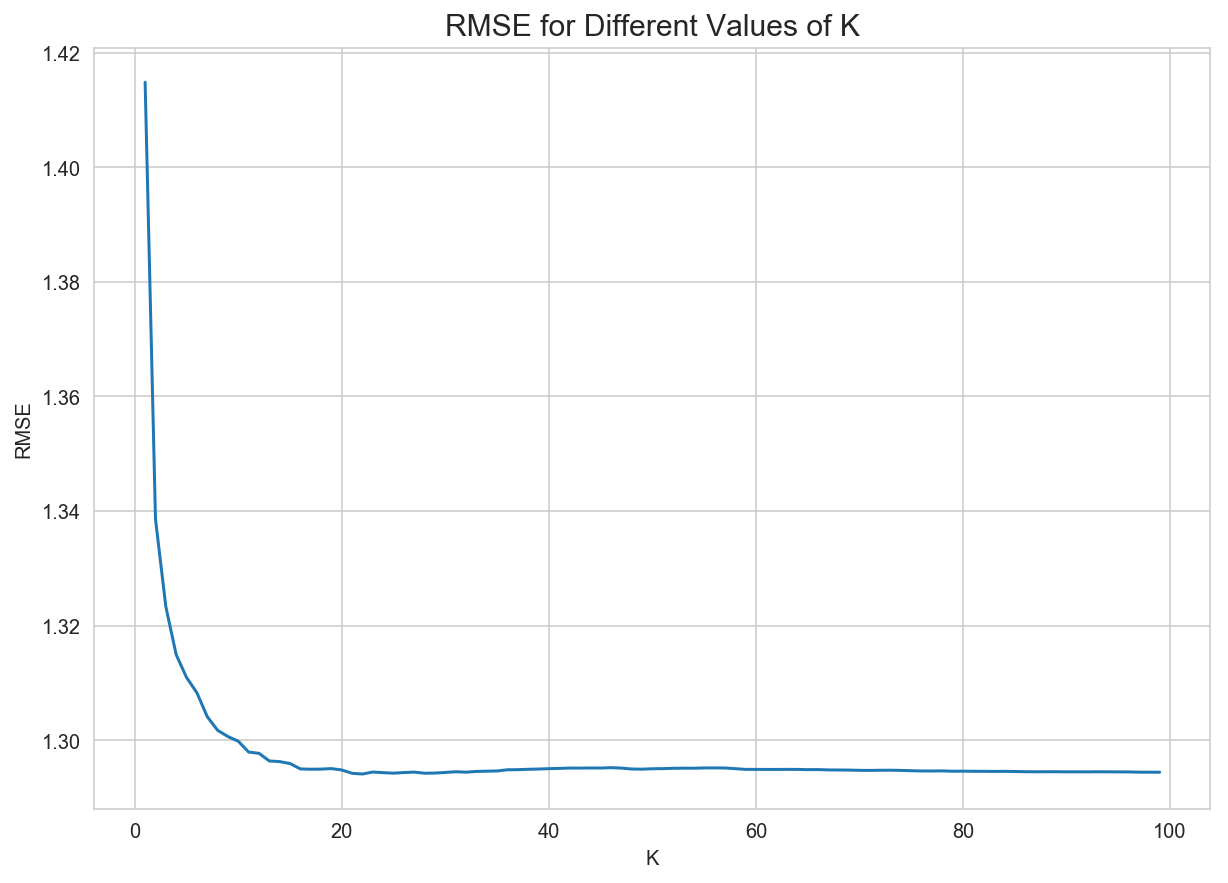

In [160]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNWithZScore', 
                   sim_options={'name': 'msd', 'user_based': True})

In [161]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
21,22,1.294122
20,21,1.294242
27,28,1.294256
24,25,1.294267
28,29,1.294288


In [162]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNWithZScore(k=best_k, sim_options={'name': 'msd', 'user_based': True})
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


### 7.A.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [163]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [164]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 10345078):
                                        product_title  star_rating
1621                            God of War: Ascension            5
4031                   Mortal Kombat Komplete Edition            5
5094                   Uncharted 3: Drake's Deception            5
5568     Batman: Arkham City Game of the Year Edition            5
7888                                  Resident Evil 6            5
14548      Call of Duty: Black Ops II - PlayStation 3            5
16008                      Need for Speed Most Wanted            5
17495                                    Dead Space 3            5
17997                                   Battlefield 3            5
18677                                     Max Payne 3            5
19033                   Assassin's Creed: Brotherhood            5
19200                            Assassin's Creed III            5
22727                                        LA Noire            5
23741           

In [165]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (UU - KNNWithZScore - MSD):', prec)


Precision (UU - KNNWithZScore - MSD): 0.0083494395052184


In [166]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (UU - KNNWithZScore - MSD):', mean_ap)


MAP (UU - KNNWithZScore - MSD): 0.07505408886692184


In [167]:
algo_7A = {'Model': 'II - KNNWithZScore - MSD',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [168]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNWithZScore',
#             sim_options={'name': 'cosine', 'user_based': True})

### 7.A.4. Make Recommendations for New Customer

In [169]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Computing the msd similarity matrix...
Done computing similarity matrix.


,items,rating
112,Killzone 3,5.0
141,Michael Jackson The Experience,5.0
123,Dance Central 2 - Xbox 360,5.0
128,Lego Star Wars: The Complete Saga,5.0
129,Carnival Games,5.0
132,Mass Effect 2,5.0
136,God of War III,5.0
139,Donkey Kong Country Returns,5.0
140,Super Smash Bros Melee,5.0
142,Mario Kart DS,5.0


<br>
## 7.B. User-User Collaborative Filtering (KNNWithZScore - Pearson-baseline)

A basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

$${\normalsize \hat{r}_{ui} = \mu_u + \sigma_u \frac{ \sum\limits_{v \in N^k_i(u)}\text{sim}(u, v) \cdot (r_{vi} - \mu_v) / \sigma_v} {\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$\mu_u$ - Mean rating for user $u$.<br>
$\sigma_u$ - Z-score normalization of user $u$ ratings.<br> 
${v \in N^k_u(u)}$ - $v$ users in $k$ neighborhood most similar to user $u$ for item $i$.<br>
$\text{sim}(u, v)$ - **Pearson-baseline** similarity between user $u$ and $v$.<br>
$(r_{vi} - \mu_v) / \sigma_v$ - Deviation of rating for user $v$ item $i$ and mean rating for user $v$, normalized by Z-score of user $v$ ratings, $\sigma_v$.<br>

### 7.B.1. Train Model

In [170]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNWithZScore(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### 7.B.2. Evaluate Model (RMSE)

In [171]:
# Evaluate test set
print("User-based (UU - KNNWithZScore - Pearson-baseline) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

User-based (UU - KNNWithZScore - Pearson-baseline) Model : Test Set
RMSE: 1.3452


**Search Best K based on RMSE**

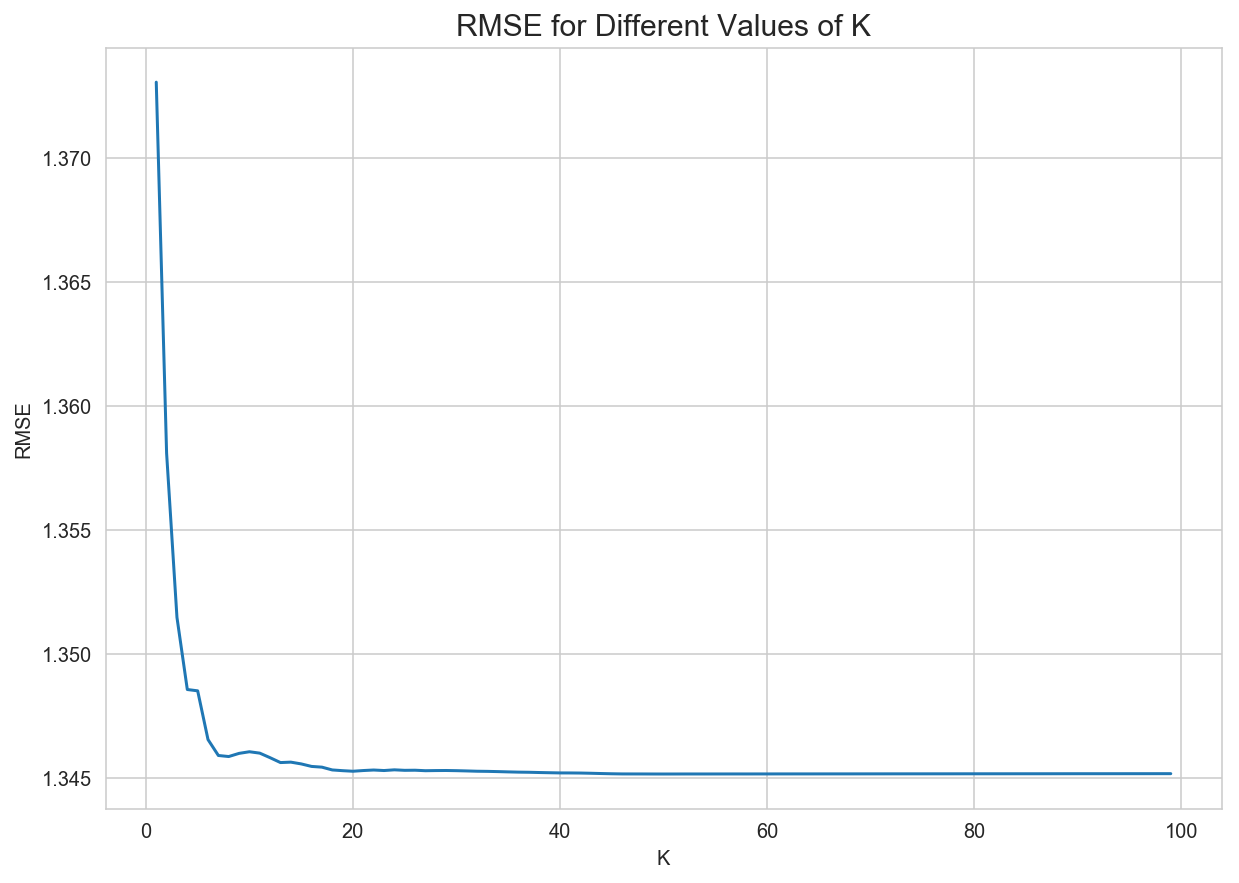

In [172]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNWithZScore', 
                   sim_options={'name': 'pearson_baseline', 'user_based': True})

In [173]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
49,50,1.345160
50,51,1.345161
48,49,1.345161
53,54,1.345162
51,52,1.345162


In [174]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNWithZScore(k=best_k, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### 7.B.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [175]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [176]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 10345078):
                                        product_title  star_rating
1621                            God of War: Ascension            5
4031                   Mortal Kombat Komplete Edition            5
5094                   Uncharted 3: Drake's Deception            5
5568     Batman: Arkham City Game of the Year Edition            5
7888                                  Resident Evil 6            5
14548      Call of Duty: Black Ops II - PlayStation 3            5
16008                      Need for Speed Most Wanted            5
17495                                    Dead Space 3            5
17997                                   Battlefield 3            5
18677                                     Max Payne 3            5
19033                   Assassin's Creed: Brotherhood            5
19200                            Assassin's Creed III            5
22727                                        LA Noire            5
23741           

In [177]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (UU - KNNWithZScore - Pearson-baseline):', prec)


Precision (UU - KNNWithZScore - Pearson-baseline): 0.012884937508053087


In [178]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (UU - KNNWithZScore - Pearson-baseline):', mean_ap)


MAP (UU - KNNWithZScore - Pearson-baseline): 0.145706949797542


In [179]:
algo_7B = {'Model': 'II - KNNWithZScore - Pearson-baseline',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [180]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNWithZScore',
#             sim_options={'name': 'pearson', 'user_based': True})

### 7.B.4. Make Recommendations for New Customer

In [181]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


,items,rating
112,Killzone 3,5.0
146,Super Mario 64,5.0
135,Rocksmith,5.0
136,God of War III,5.0
137,New Super Mario Bros,5.0
139,Donkey Kong Country Returns,5.0
140,Super Smash Bros Melee,5.0
141,Michael Jackson The Experience,5.0
142,Mario Kart DS,5.0
143,Mario Kart: Double Dash,5.0


<br>
## 8.A. Item-Item Collaborative Filtering (KNNWithZScore - MSD)

A basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

$${\normalsize \hat{r}_{ui} = \mu_i + \sigma_i \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - \mu_j) / \sigma_j} {\sum\limits_{j\in N^k_u(i)} \text{sim}(i, j)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$\mu_i$ - Mean rating for item $i$.<br>
$\sigma_i$ - Z-score normalization of item $i$ ratings.<br>
${j \in N^k_u(i)}$ - $j$ items in $k$ neighborhood most similar to item $i$ for user $u$.<br>
$\text{sim}(i, j)$ - **MSD** similarity between items $i$ and $j$.<br>
$(r_{uj} - \mu_j) / \sigma_j$ - Deviation of rating for item $j$ user $u$ and mean rating for item $j$, normalized by Z-score of item $j$ ratings, $\sigma_j$.<br>

### 8.A.1. Train Model

In [182]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNWithZScore(k=50, sim_options={'name': 'msd', 'user_based': False})
algo.fit(trainset)


Computing the msd similarity matrix...
Done computing similarity matrix.


### 8.A.2. Evaluate Model (RMSE)

In [183]:
# Evaluate test set
print("Item-based (II - KNNWithZScore - MSD) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

Item-based (II - KNNWithZScore - MSD) Model : Test Set
RMSE: 1.2318


**Search Best K based on RMSE**

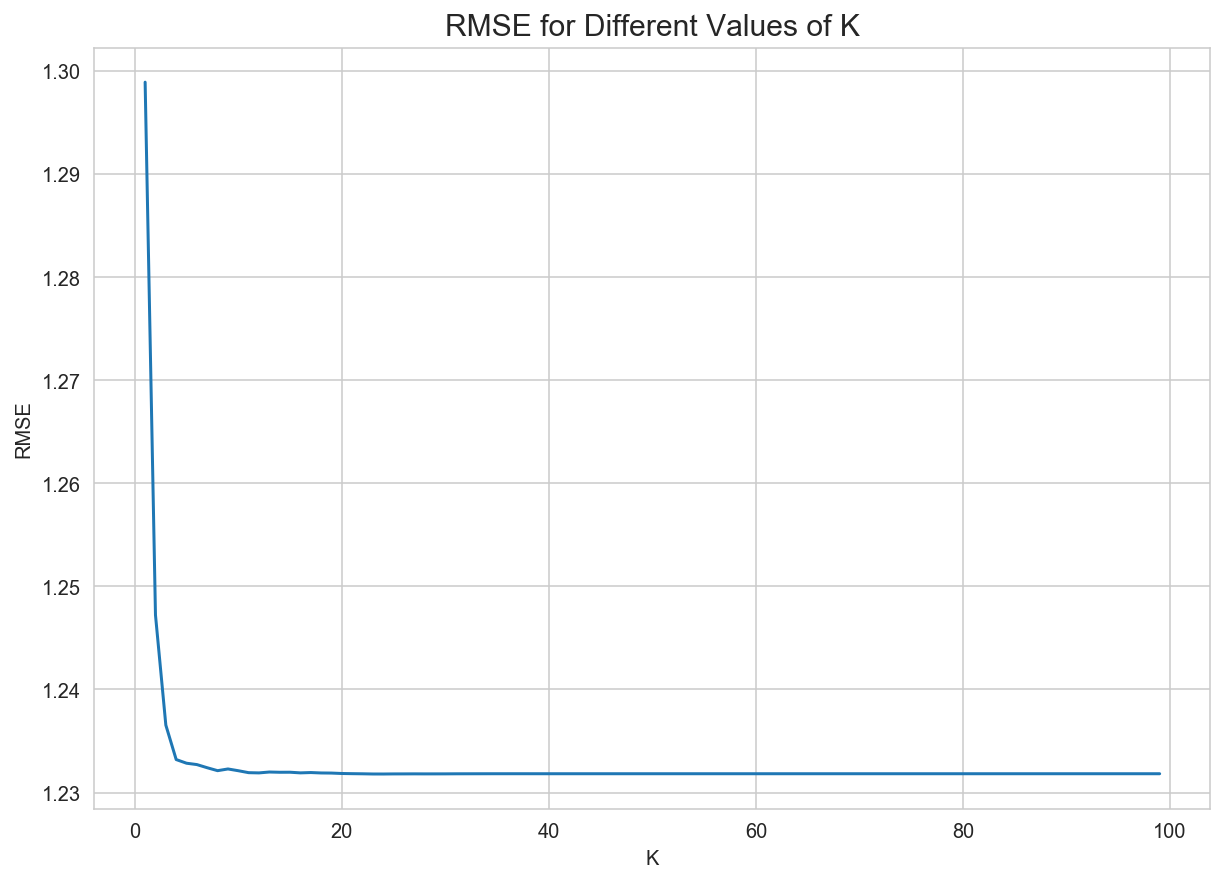

In [184]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNWithZScore', 
                   sim_options={'name': 'msd', 'user_based': False})

In [185]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
23,24,1.231802
22,23,1.231804
24,25,1.231811
25,26,1.231813
27,28,1.231814


In [186]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNWithZScore(k=best_k, sim_options={'name': 'msd', 'user_based': False})
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


### 8.A.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [187]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [188]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 10345078):
                                        product_title  star_rating
1621                            God of War: Ascension            5
4031                   Mortal Kombat Komplete Edition            5
5094                   Uncharted 3: Drake's Deception            5
5568     Batman: Arkham City Game of the Year Edition            5
7888                                  Resident Evil 6            5
14548      Call of Duty: Black Ops II - PlayStation 3            5
16008                      Need for Speed Most Wanted            5
17495                                    Dead Space 3            5
17997                                   Battlefield 3            5
18677                                     Max Payne 3            5
19033                   Assassin's Creed: Brotherhood            5
19200                            Assassin's Creed III            5
22727                                        LA Noire            5
23741           

In [189]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (II - KNNWithZScore - MSD):', prec)


Precision (II - KNNWithZScore - MSD): 0.009586393505991497


In [190]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (II - KNNWithZScore - MSD):', mean_ap)


MAP (II - KNNWithZScore - MSD): 0.10503452172494175


In [191]:
algo_8A = {'Model': 'II - KNNWithZScore - MSD',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [192]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNWithZScore',
#             sim_options={'name': 'cosine', 'user_based': False})

### 8.A.4. Make Recommendations for New Customer

In [193]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Computing the msd similarity matrix...
Done computing similarity matrix.


,items,rating
112,Killzone 3,5.0
127,Demon's Souls,5.0
205,Grand Theft Auto: San Andreas,5.0
118,Fallout 3: Game of The Year Edition,5.0
120,Batman Arkham Asylum Goty,5.0
121,Heavy Rain - Greatest Hits,5.0
122,PS3 Journey Collection,5.0
123,Dance Central 2 - Xbox 360,5.0
124,Dead Space 3,5.0
126,Uncharted: Drake's Fortune - Playstation 3,5.0


<br>
## 8.B. Item-Item Collaborative Filtering (KNNWithZScore - Pearson-baseline)

A basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

$${\normalsize \hat{r}_{ui} = \mu_i + \sigma_i \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - \mu_j) / \sigma_j} {\sum\limits_{j\in N^k_u(i)} \text{sim}(i, j)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$\mu_i$ - Mean rating for item $i$.<br>
$\sigma_i$ - Z-score normalization of item $i$ ratings.<br>
${j \in N^k_u(i)}$ - $j$ items in $k$ neighborhood most similar to item $i$ for user $u$.<br>
$\text{sim}(i, j)$ - **Pearson-baseline** similarity between items $i$ and $j$.<br>
$(r_{uj} - \mu_j) / \sigma_j$ - Deviation of rating for item $j$ user $u$ and mean rating for item $j$, normalized by Z-score of item $j$ ratings, $\sigma_j$.<br>

### 8.B.1. Train Model

In [194]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNWithZScore(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### 8.B.2. Evaluate Model (RMSE)

In [195]:
# Evaluate test set
print("Item-based (KNNWithZScore - Pearson-baseline) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

Item-based (KNNWithZScore - Pearson-baseline) Model : Test Set
RMSE: 1.2100


**Search Best K based on RMSE**

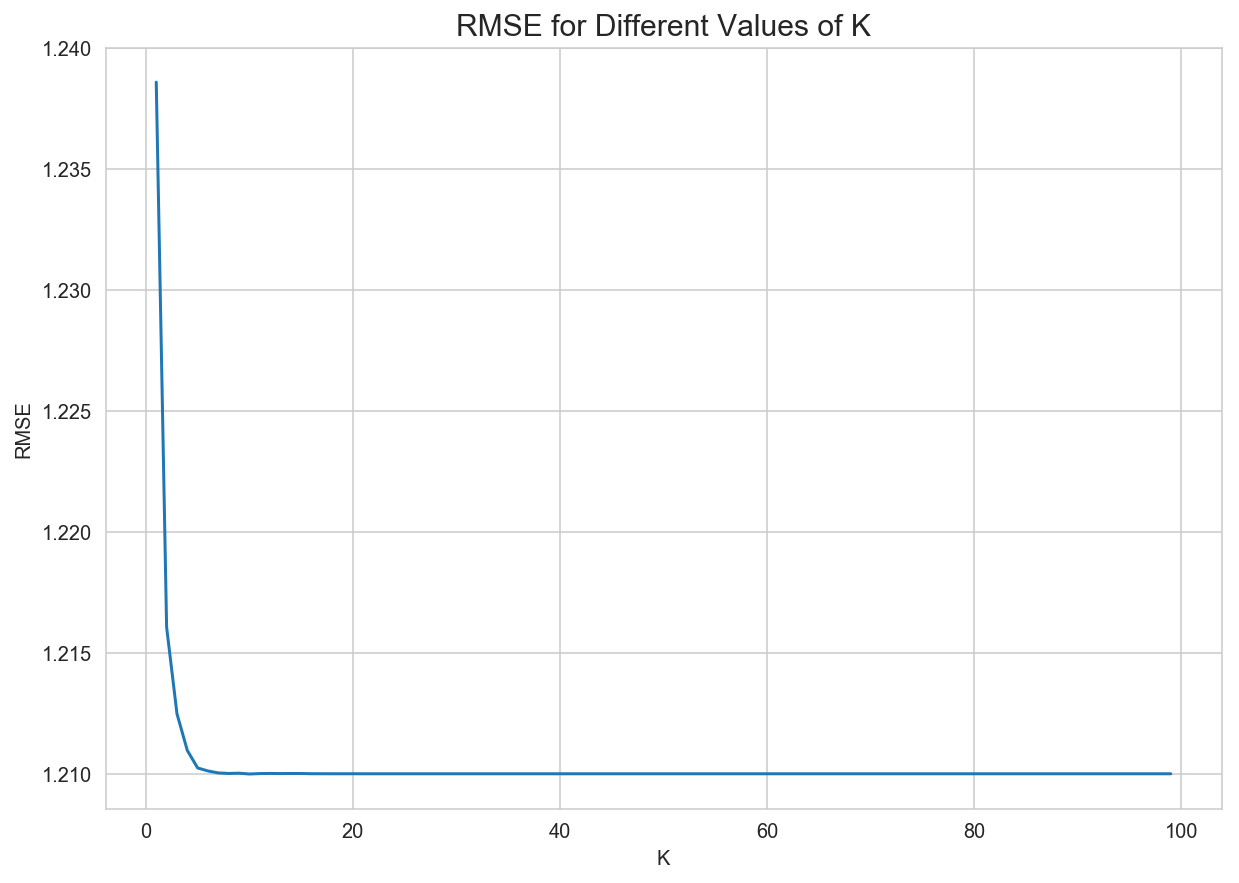

In [196]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNWithZScore', 
                   sim_options={'name': 'pearson_baseline', 'user_based': False})

In [197]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
9,10,1.210003
49,50,1.210013
71,72,1.210013
70,71,1.210013
69,70,1.210013


In [198]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNWithZScore(k=best_k, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### 8.B.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [199]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [200]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 10345078):
                                        product_title  star_rating
1621                            God of War: Ascension            5
4031                   Mortal Kombat Komplete Edition            5
5094                   Uncharted 3: Drake's Deception            5
5568     Batman: Arkham City Game of the Year Edition            5
7888                                  Resident Evil 6            5
14548      Call of Duty: Black Ops II - PlayStation 3            5
16008                      Need for Speed Most Wanted            5
17495                                    Dead Space 3            5
17997                                   Battlefield 3            5
18677                                     Max Payne 3            5
19033                   Assassin's Creed: Brotherhood            5
19200                            Assassin's Creed III            5
22727                                        LA Noire            5
23741           

In [201]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (II - KNNWithZScore - Pearson-baseline):', prec)


Precision (II - KNNWithZScore - Pearson-baseline): 0.01136451488210282


In [202]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (II - KNNWithZScore - Pearson-baseline):')


MAP (II - KNNWithZScore - Pearson-baseline):


In [203]:
algo_8B = {'Model': 'II - KNNWithZScore - Pearson-baseline',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [204]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNWithZScore',
#             sim_options={'name': 'pearson', 'user_based': False})

### 8.B.4. Make Recommendations for New Customer

In [205]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


,items,rating
112,Killzone 3,5.0
177,Forza Horizon,5.0
101,Borderlands,5.0
160,The Elder Scrolls Anthology,5.0
99,God Of War Collection,5.0
98,Fallout 3,5.0
97,Medal of Honor: Allied Assault - PC,5.0
164,Ryse: Son of Rome Day One Edition - Xbox One,5.0
94,Call of Duty: World at War,5.0
93,Halo 3: ODST,5.0


### Conclusion

In [206]:
scores = [algo_1A, algo_1B,
          algo_2A, algo_2B,
          algo_3A, algo_3B,
          algo_4A, algo_4B,
          algo_5A, algo_5B,
          algo_6A, algo_6B,
          algo_7A, algo_7B,
          algo_8A, algo_8B]

scores_df(scores).sort_values(by='MAP', ascending=False)

,Model,RMSE,Unranked Precision,MAP
5,UU - KNNwithMeans - Pearson-baseline,1.340949,0.013787,0.153827
1,UU - KNNBasic - Pearson-baseline,1.309343,0.013040,0.149599
13,II - KNNWithZScore - Pearson-baseline,1.345160,0.012885,0.145707
11,II - KNNBaseline - Pearson-baseline,1.206316,0.013967,0.141018
3,II - KNNBasic - Pearson-baseline,1.277221,0.013555,0.131579
15,II - KNNWithZScore - Pearson-baseline,1.210013,0.011365,0.120402
7,II - KNNwithMeans - Pearson-baseline,1.215083,0.011596,0.118923
10,II - KNNBaseline - MSD,1.227468,0.011339,0.116442
9,UU - KNNBaseline - Pearson-baseline,1.225315,0.011081,0.108311
14,II - KNNWithZScore - MSD,1.231828,0.009586,0.105035
